<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W3D5_initial_commit/tutorials/W3D5_DeepLearning2/W3D5_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy 2020: Week 3, Day 5
# Tutorial 3: Autoencoders applications

---
## Autoencoder applications
Now that we know how to construct powerful autoencoders with 2D latent space, let's see them in action with simple applications and do a little bit of hands-on practice.

The outro video presents a neuroscience application for spike sorting. Also, see [here](https://www.nature.com/articles/s41592-018-0109-9) how to replicate the input-output relationship of real networks of neurons with autoencoders.

###Objectives:
- Analyze how autoencoders perceive transformed data  (noise, missing image parts, and rotation), and how that evolves with training
- Use autoencoders to help visualize previously unseen data

Video available at https://youtube.com/watch?v=GFKgRCLoqvo


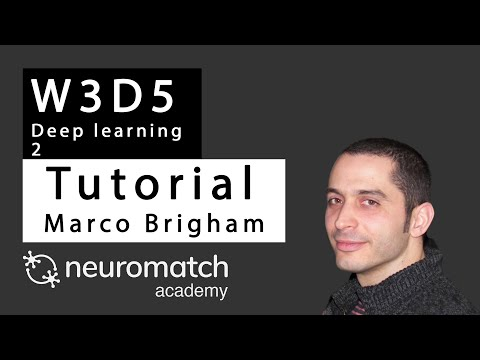

In [1]:
#@title Video: Intro

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="GFKgRCLoqvo", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Setup
Please execute the cell(s) below to initialize the notebook environment.

In [2]:
# Imports
import numpy as np                 # import numpy
import matplotlib.pyplot as plt    # import matplotlib
import os
import math
import scipy as sp
from scipy import ndimage

from IPython import display        
from IPython.display import YouTubeVideo

from sklearn.datasets import fetch_openml

import torch
from torch import nn, optim
import torchvision

In [3]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

fig_w, fig_h = (8, 6)
plt.rcParams['figure.figsize'] = (fig_w, fig_h)
plt.rcParams['font.size'] = 14

In [4]:
# @title Helper functions
def downloadMNIST():
  """
  Download MNIST dataset and transform it to torch.Tensor
  
  Args:
    None

  Returns:
    x_train : training images (torch.Tensor) (60000, 28, 28)
    x_test  : test images (torch.Tensor) (10000, 28, 28)
    y_train : training labels (torch.Tensor) (60000, )
    y_train : test labels (torch.Tensor) (10000, )
  """
  X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
  # Trunk the data
  n_train = 60000
  n_test = 10000

  train_idx = np.arange(0,n_train)
  test_idx = np.arange(n_train+1,n_train+n_test)

  x_train, y_train = X[train_idx], y[train_idx]
  x_test, y_test = X[test_idx], y[test_idx]

  # Transform np.ndarrays to torch.Tensor
  x_train = torch.from_numpy(np.reshape(x_train, (len(x_train),28,28))).float()
  x_test = torch.from_numpy(np.reshape(x_test, (len(x_test),28,28))).float()
  y_train, y_test = torch.from_numpy(y_train.astype(float)), torch.from_numpy(y_test.astype(float))

  return (x_train, y_train, x_test, y_test)

def eval_mse(y_pred, y_true):
  """
  Evaluates mean square error (MSE) between y_pred and y_true
  
  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples
            
  Returns:
    MSE(y_pred, y_true)
  """

  with torch.no_grad():
    criterion = nn.MSELoss()
    loss = criterion(y_pred, y_true)

  return float(loss)


def eval_bce(y_pred, y_true):
  """
  Evaluates binary cross-entropy (BCE) between y_pred and y_true
  
  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples
            
  Returns:
    BCE(y_pred, y_true)
  """
  
  with torch.no_grad():
    criterion = nn.BCELoss()
    loss = criterion(y_pred, y_true)

  return float(loss)


def plot_row(images, show_n=10, image_shape=None):
  """
  Plots rows of images from list of iterables (iterables: list, numpy array 
  or torch.Tensor). Also accepts single iterable.
  Randomly selects images in each list element if item count > show_n.
  
  
  Args:
    images (iterable or list of iterables)
        single iterable with images, or list of iterables

    show_n (integer)
        maximum number of images per row

    image_shape (tuple or list)
        original shape of image if vectorized form
            
  Returns:
    Nothing.
  """

  if not isinstance(images, (list, tuple)):
    images = [images]

  for items_idx, items in enumerate(images):

    items = np.array(items)
    if items.ndim==1:
      items = np.expand_dims(items, axis=0)

    if len(items)>show_n:
      selected = np.random.choice(len(items), show_n, replace=False)
      items = items[selected]

    if image_shape is not None:
      items = items.reshape([-1]+list(image_shape))

    fig = plt.figure(figsize=(len(items)*1.5, 2))
    for image_idx, image in enumerate(items):

      plt.subplot(1, len(items), image_idx + 1)
      plt.imshow(image, cmap='gray', vmin=image.min(), vmax=image.max())
      plt.axis('off')

    plt.tight_layout()


def to_s2(u):
  """
  Projects 3D coordinates to spherical coordinates (theta, phi) surface of 
  unit sphere S2.
  theta: [0, pi]
  phi: [-pi, pi]   

  Args:
    u (list, numpy array or torch.Tensor of floats)
        3D coordinates
            
  Returns:
    Sperical coordinates (theta, phi) on surface of unit sphere S2.
  """

  x, y, z = (u[:,0], u[:,1], u[:,2])
  r = np.sqrt(x**2 + y**2 + z**2)
  theta = np.arccos(z/r)
  phi = np.arctan2(x, y)

  return np.array([theta, phi]).T


def to_u3(s):
  """
  Converts from 2D coordinates on surface of unit sphere S2 to 3D coordinates 
  (on surface of S2), i.e. (theta, phi) ---> (1, theta, phi).
  
  Args:
    s (list, numpy array or torch.Tensor of floats)
        2D coordinates on unit sphere S_2
            
  Returns:
    3D coordinates on surface of unit sphere S_2
  """

  theta, phi = (s[:,0], s[:,1])
  x = np.sin(theta) * np.sin(phi)
  y = np.sin(theta) * np.cos(phi)
  z = np.cos(theta)

  return np.array([x, y, z]).T


def xy_lim(x):
  """
  Return arguments for plt.xlim and plt.ylim calculated from minimum 
  and maximum of x.
  
  
  Args:
    x (list, numpy array or torch.Tensor of floats)
        data to be plotted
            
  Returns:
    Nothing.
  """
  x_min = np.min(x, axis=0)
  x_max = np.max(x, axis=0)

  return [x_min[0], x_max[0]], [x_min[1], x_max[1]]
    

def plot_generative(x, decoder_fn, image_shape, n_row=16, s2=False):
  """
  Plots images reconstructed by decoder_fn from a 2D grid in 
  latent space that is determined by minimum and maximum values in x.    
  
  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D or 3D coordinates in latent space 

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    n_row (integer)
        number of rows in grid

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

            
  Returns:
    Nothing.
  """

  if s2:
    x = to_s2(np.array(x))

  xlim, ylim = xy_lim(np.array(x))
  
  dx = (xlim[1]-xlim[0])/n_row
  grid = [np.linspace(ylim[0]+dx/2, ylim[1]-dx/2, n_row),
          np.linspace(xlim[0]+dx/2, xlim[1]-dx/2, n_row)]

  canvas = np.zeros((image_shape[0]*n_row, image_shape[1]*n_row))

  cmap = plt.get_cmap('gray')

  for j, latent_y in enumerate(grid[0][::-1]):
    for i, latent_x in enumerate(grid[1]):

      latent = np.array([latent_x, latent_y], dtype=np.float32)

      if s2:
        latent = to_u3(np.expand_dims(latent, axis=0))

      with torch.no_grad():
        x_decoded = decoder_fn(torch.from_numpy(latent))
      
      x_decoded = x_decoded.reshape(image_shape)

      canvas[j*image_shape[0]: (j+1)*image_shape[0],
              i*image_shape[1]: (i+1)*image_shape[1]] = x_decoded

  plt.imshow(canvas, cmap=cmap, vmin=canvas.min(), vmax=canvas.max())
  plt.axis('off')


def plot_latent(x, y, show_n=500, s2=False, fontdict=None):
  """
  Plots in 2D latent space locations the digit class of each sample.
  
  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space 

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    n_row (integer)
        number of samples

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

    fontdict (dictionary)
        style option for plt.text
            
  Returns:
    Nothing.
  """

  if fontdict is None:
    fontdict = {'weight': 'bold', 'size': 10}

  if s2:
    x = to_s2(np.array(x))

  cmap = plt.get_cmap('tab10')

  if len(x)>show_n:
    selected = np.random.choice(len(x), show_n, replace=False)
    x = x[selected]
    y = y[selected]

  for my_x, my_y in zip(x, y):
    plt.text(my_x[0], my_x[1], str(int(my_y)),
              color=cmap(int(my_y)/10.),
              fontdict=fontdict,
              alpha=0.8)
      
  xlim, ylim = xy_lim(np.array(x))
  plt.xlim(xlim)
  plt.ylim(ylim)


def plot_latent_generative(x, y, decoder_fn, image_shape, s2=False, title=None):
  """
  Two horizontal subplots generated with plot_latent and plot_generative. 

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space 

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)
        
    title (string)
        plot title
            
  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=(12,6))

  if title is not None:
    fig.suptitle(title, y=1.05, fontsize=16)

  ax = fig.add_subplot(121)
  ax.set_title('Latent space map')
  plot_latent(x, y, s2=s2)

  ax = fig.add_subplot(122)
  ax.set_title('Reconstruction grid')    
  plot_generative(x, decoder_fn, image_shape, s2=s2)

  plt.tight_layout()
  plt.show()


def plot_latent_ab(x1, x2, y, selected_idx=None, 
                   title_a='Before', title_b='After', show_n=500, s2=False):
  """
  Two horizontal subplots generated with plot_latent. 

  Args:
    x1 (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space (left plot)

    x2 (list, numpy array or torch.Tensor of floats)
        digit class of each sample (right plot)

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    selected_idx (list of integers)
        indexes of elements to be plotted

    show_n (integer)
        maximum number of samples in each plot

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)
            
  Returns:
    Nothing.
  """

  fontdict = {'weight': 'bold', 'size': 12}

  if len(x1)>show_n:

    if selected_idx is None:
      selected_idx = np.random.choice(len(x1), show_n, replace=False)

    x1 = x1[selected_idx]
    x2 = x2[selected_idx]
    y = y[selected_idx]

  data = np.concatenate([x1, x2])
  
  if s2:
    xlim, ylim = xy_lim(to_s2(data))

  else:
    xlim, ylim = xy_lim(data)

  fig = plt.figure(figsize=(12,6))

  ax = plt.subplot(121)
  ax.set_title(title_a)
  plot_latent(x1, y, fontdict=fontdict, s2=s2)
  plt.xlim(xlim)
  plt.ylim(ylim)

  ax = plt.subplot(122)
  ax.set_title(title_b)
  plot_latent(x2, y, fontdict=fontdict, s2=s2)
  plt.xlim(xlim)
  plt.ylim(ylim)
  plt.tight_layout()


def runSGD(net, input_train, input_test, out_train=None, out_test=None,
           optimizer=None, criterion='bce', n_epochs=10, batch_size=32, 
           verbose=True):
  """
  Trains autoencoder network with stochastic gradient descent with  
  optimizer and loss criterion. Train samples are shuffled, and loss is 
  displayed at the end of each opoch for both MSE and BCE. Plots training loss 
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN network (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    out_train (torch.Tensor)
        optional target images from train set

    out_test (torch.Tensor)
        optional target images from test set

    optimizer (torch optimizer)
        optional target images from train set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data
        
    batch_size (integer)
        number of element in mini-batches
        
    verbose (boolean)
        whether to print epoch loss and training loss plot          
            
  Returns:
    Nothing.
  """

  if out_train is not None and out_test is not None:
    different_output = True
  else:
    different_output = False

  # Initialize loss function
  if criterion=='mse':
    loss_fn = nn.MSELoss()
  elif criterion=='bce':
    loss_fn = nn.BCELoss()
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Initialize SGD optimizer
  if optimizer is None:
    optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    shuffle_idx = np.random.permutation(len(input_train))
    batches = torch.split(input_train[shuffle_idx], batch_size)

    if different_output:
      batches_out = torch.split(out_train[shuffle_idx], batch_size)
    
    for batch_idx, batch in enumerate(batches):

      output_train = model(batch)

      if different_output:
        loss = loss_fn(output_train, batches_out[batch_idx])
      else:
        loss = loss_fn(output_train, batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      track_loss += [float(loss)]
    
    loss_epoch = '{}/{}'.format(i+1, n_epochs)
    with torch.no_grad():
      output_train = model(input_train)
      if different_output:
        loss_train = loss_fn(output_train, out_train)
      else:
        loss_train = loss_fn(output_train, input_train)

      loss_epoch += '\t {:.4f}'.format(loss_train)

      output_test = model(input_test)
      if different_output:
        loss_test = loss_fn(output_test, out_test)
      else:
        loss_test = loss_fn(output_test, input_test)

      loss_epoch += '\t\t {:.4f}'.format(loss_test)

    if verbose:
      print(loss_epoch)

  # Print loss
  if different_output:
    loss_mse = '\nmse\t {:0.4f}'.format(eval_mse(output_train, out_train))
    loss_mse += '\t\t {:0.4f}'.format(eval_mse(output_test, out_test))
  else:
    loss_mse = '\nmse\t {:0.4f}'.format(eval_mse(output_train, input_train))
    loss_mse += '\t\t {:0.4f}'.format(eval_mse(output_test, input_test))
  print(loss_mse)

  if different_output:
    loss_bce = 'bce\t {:0.4f}'.format(eval_bce(output_train, out_train))
    loss_bce += '\t\t {:0.4f}'.format(eval_bce(output_test, out_test))
  else:
    loss_bce = 'bce\t {:0.4f}'.format(eval_bce(output_train, input_train))
    loss_bce += '\t\t {:0.4f}'.format(eval_bce(output_test, input_test))
  print(loss_bce)

  # Plot loss
  if verbose:
    step = int(np.ceil(len(track_loss)/500))
    plt.figure()
    plt.plot(track_loss[::step], 'C1')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.xlim([0, None])
    plt.ylim([0, None])
    plt.show()


def image_occlusion(x, image_shape):
  """
  Randomly selects on quadrant of images and sets to zeros.

  Args:
    x (torch.Tensor of floats)
        vectorized images

    image_shape (tuple or list)
        original shape of image
            
  Returns:
    torch.Tensor.
  """

  selection = np.random.choice(4, len(x))

  my_x = np.array(x).reshape(-1, image_shape[0], image_shape[1])

  my_x[selection==0, :int(image_shape[0]/2), :int(image_shape[1]/2)] = 0
  my_x[selection==1, int(image_shape[0]/2):, :int(image_shape[1]/2)] = 0
  my_x[selection==2, :int(image_shape[0]/2), int(image_shape[1]/2):] = 0
  my_x[selection==3, int(image_shape[0]/2):, int(image_shape[1]/2):] = 0

  my_x = my_x.reshape(x.shape)

  return torch.from_numpy(my_x)


def image_rotation(x, deg, image_shape):
  """
  Randomly rotates images by +- deg degrees.

  Args:
    x (torch.Tensor of floats)
        vectorized images

    deg (integer)
        rotation range

    image_shape (tuple or list)
        original shape of image
            
  Returns:
    torch.Tensor.
  """

  my_x = np.array(x).reshape(-1, image_shape[0], image_shape[1])

  for idx, item in enumerate(my_x):
    my_deg = deg*2*np.random.random()-deg
    my_x[idx] = sp.ndimage.rotate(my_x[idx], my_deg, reshape=False)

  my_x = my_x.reshape(x.shape)

  return torch.from_numpy(my_x)


class AutoencoderClass(nn.Module):
  """
  Deep autoencoder network object (nn.Module) with optional L2 normalization 
  of activations in bottleneck layer.

  Args:
      input_size (integer)
          size of input samples
          
      s2 (boolean)
          whether to L2 normalize activatinos in bottleneck layer
            
  Returns:
      Autoencoder object inherited from nn.Module class.
  """

  def __init__(self, input_size=784, s2=False):
      
    super().__init__()
    
    self.input_size = input_size
    self.s2 = s2
    
    if s2:
      self.encoding_size = 3
        
    else:
      self.encoding_size = 2
        
    self.enc1 = nn.Linear(self.input_size, int(self.input_size/2))
    self.enc1_f = nn.PReLU()
    self.enc2 = nn.Linear(int(self.input_size/2), self.encoding_size*32)
    self.enc2_f = nn.PReLU()
    self.enc3 = nn.Linear(self.encoding_size*32, self.encoding_size)
    self.enc3_f = nn.PReLU()
    self.dec1 = nn.Linear(self.encoding_size, self.encoding_size*32)
    self.dec1_f = nn.PReLU()
    self.dec2 = nn.Linear(self.encoding_size*32, int(self.input_size/2))
    self.dec2_f = nn.PReLU()
    self.dec3 = nn.Linear(int(self.input_size/2), self.input_size)
    self.dec3_f = nn.Sigmoid()

  def encoder(self, x):
    """
    Encoder component.
    """                
    x = self.enc1_f(self.enc1(x))
    x = self.enc2_f(self.enc2(x))
    x = self.enc3_f(self.enc3(x))
    
    if self.s2:
        x = nn.functional.normalize(x, p=2, dim=1)

    return x


  def decoder(self, x):
    """
    Decoder component.
    """        
    x = self.dec1_f(self.dec1(x))
    x = self.dec2_f(self.dec2(x))
    x = self.dec3_f(self.dec3(x))

    return x


  def forward(self, x):
    """
    Forward pass.
    """
    x = self.encoder(x)
    x = self.decoder(x)

    return x


def save_checkpoint(net, optimizer, filename):
  """
  Saves a PyTorch checkpoint.

  Args:
    net (torch network)
        ANN network (nn.Module)

    optimizer (torch optimizer)
        optimizer for SGD

    filename (string)
        filename (without extension)

  Returns:
    Nothing.
  """

  torch.save({'model_state_dict': net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()},
              filename+'.pt')


def load_checkpoint(url, filename):
  """
  Loads a PyTorch checkpoint from URL is local file not present.

  Args:
    url (string)
        URL location of PyTorch checkpoint

    filename (string)
        filename (without extension)

  Returns:
    PyTorch checkpoint of saved model.
  """

  if not os.path.isfile(filename+'.pt'):
    os.system(f"wget {url}.pt")

  return torch.load(filename+'.pt')


def reset_checkpoint(net, optimizer, checkpoint):
  """
  Resets PyTorch model to checkpoint.

  Args:
    net (torch network)
        ANN network (nn.Module)

    optimizer (torch optimizer)
        optimizer for SGD

    checkpoint (torch checkpoint)
        checkpoint of saved model

  Returns:
    Nothing.
  """

  net.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## Download  and prepare MNIST dataset
We use the function `torchvision.datasets.MNIST` to download the dataset and assign train and test sets to (`x_train`, `y_train`) and (`x_test`, `y_test`), respectively.

The variable `input_size` stores the size of *vectorized* versions of the images `input_train` and `input_test`, for train and test images, respectively.

**Instructions**
* Please execute the cell below

In [5]:
# Download MNIST
x_train, y_train, x_test, y_test = downloadMNIST()

x_train = x_train/255.
x_test = x_test/255.

image_shape = x_train.shape[1:]

input_size = np.prod(image_shape)

input_train = x_train.reshape([-1, input_size])
input_test = x_test.reshape([-1, input_size])

test_selected_idx = np.random.choice(len(x_test), 10, replace=False)
train_selected_idx = np.random.choice(len(x_train), 10, replace=False)

selected_idx = np.random.choice(len(x_test), 500, replace=False)

print('size input_size', input_size)
print('shape input_train', input_train.shape)
print('shape input_train', input_test.shape)

size input_size 784
shape input_train torch.Size([60000, 784])
shape input_train torch.Size([9999, 784])


## Train or download a pre-trained model
In this exercise, we'll use `AutoencoderClass` to provide autoencoder architectures from the previous tutorial. The boolean parameter `s2` specifies the model with projection to $S_2$ sphere.

We will run the experiments from the same initial conditions by resetting the autoencoder to a reference configuration (trained for`n_epochs=25`). 

We saved the weights of the model beforehand to avoid a lengthy initial training period, and use the mechanism for loading and storing models from PyTorch. The operations are the following:
```
model = nn.Sequential(...)
or
model = AutoencoderClass()

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()},
           filename_path)

checkpoint = torch.load(filename_path)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
```
See additional [PyTorch instructions](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html), and when to use `model.eval()` and `model.train()` for more complex models.

We provide the functions `save_checkpoint`, `load_checkpoint`, and `reset_checkpoint` to implement the steps above and downloading the weights from our GitHub repo.

If downloading from GitHub fails, please uncomment the 2nd cell bellow to train the model for `n_epochs=10` and save it locally.

**Instructions**
* Please execute the cell(s) below

In [6]:
root = 'https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders'
filename = 'ae_6h_prelu_bce_adam_25e_32b'
url = os.path.join(root, filename)
s2 = False

if s2:
  filename += '_s2'
  url += '_s2'

In [7]:
model = AutoencoderClass(s2=s2)
optimizer = optim.Adam(model.parameters())

encoder = model.encoder
decoder = model.decoder

checkpoint = load_checkpoint(url, filename)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

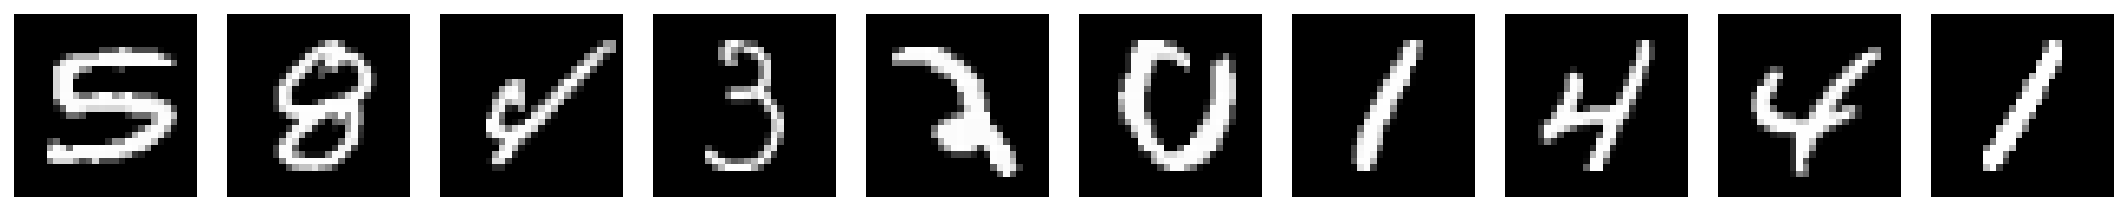

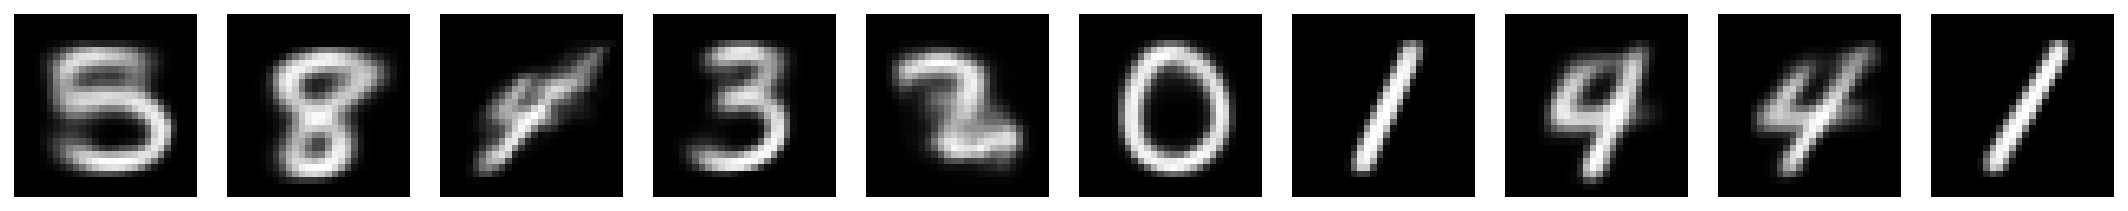

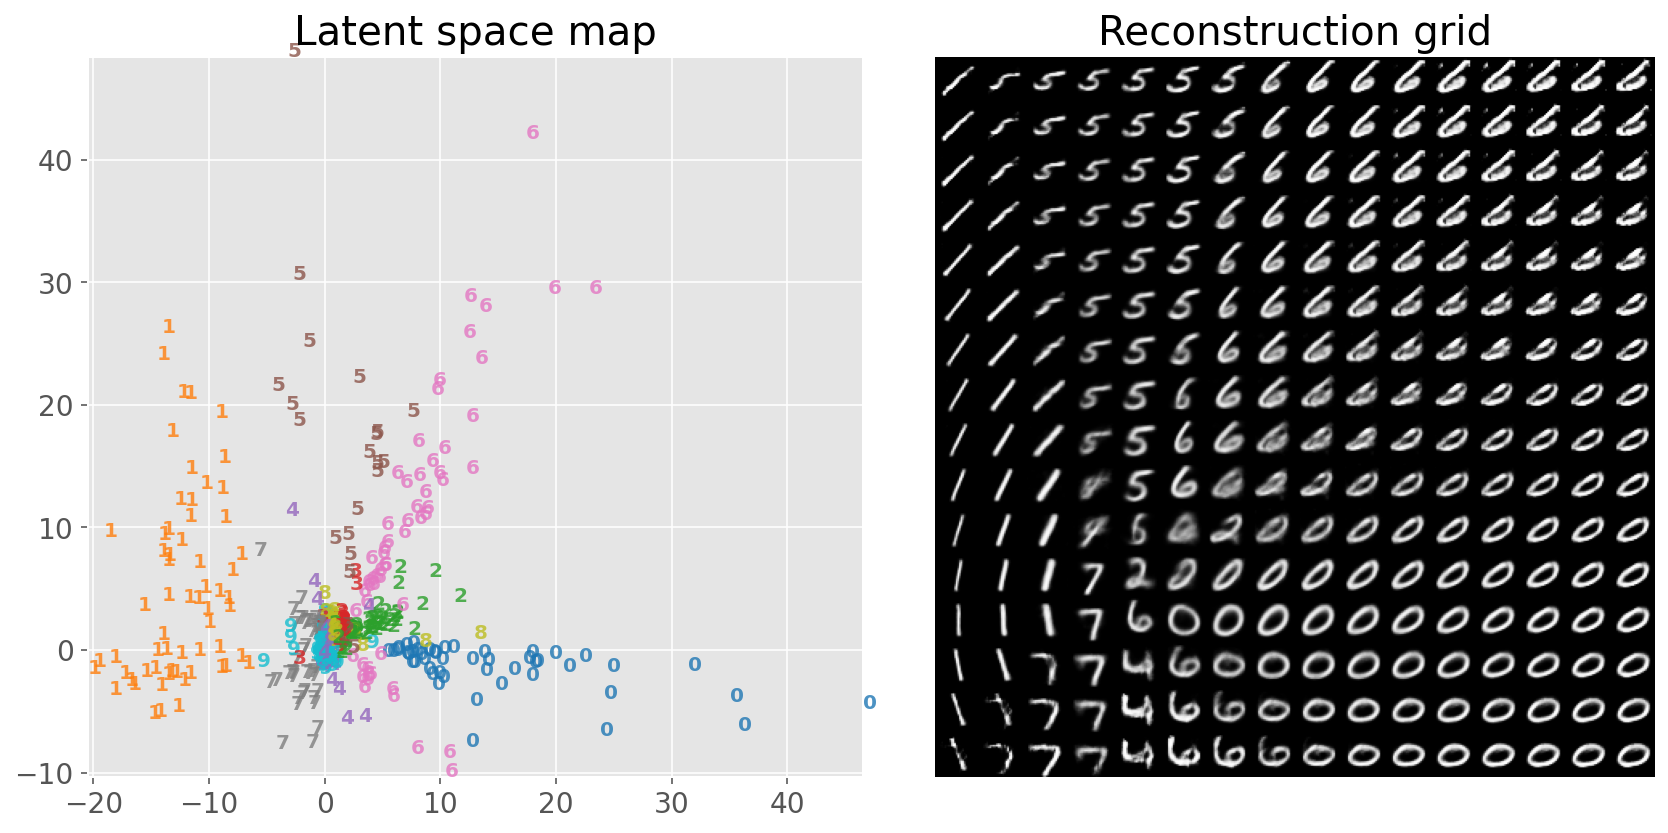

In [8]:
with torch.no_grad():
  output_test = model(input_test)
  latent_test = encoder(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]], 
         image_shape=image_shape)

plot_latent_generative(latent_test, y_test, decoder, 
                       image_shape=image_shape, s2=s2)

## Application 1: Image denoising
Cleaning noisy images is a typical demo of autoencoders. The tutorial  *W1D5 Dimensionality reduction* illustrated this task for PCA. In this exercise, we observe that autoencoders trained with clean images will output clean images, even if fed with noisy images. However, the reconstructed images will not resemble the original images (without noise). For this purpose, we need to re-train the network with noisy images on the input and clean images on the outputs.

Let's start by resetting to the reference autoencoder state, as in the last exercise.

**Instructions**
* Please execute the cells below

In [9]:
reset_checkpoint(model, optimizer, checkpoint)

with torch.no_grad():
  latent_test_ref = encoder(input_test)

### Reconstructions before re-train
Let's verify that an autoencoder trained on clean images will output clean images from noisy inputs. We visualize this by plotting three rows:
top row with noisy images inputs
middle row with reconstructions of noisy images inputs
bottom row with reconstructions of the original images (no noise)
The bottom row helps identify samples with poor reconstructions already present in the reference autoencoder state.

**Instructions**
* Please execute the cell(s) below

In [10]:
noise_factor = 0.4

input_train_noisy = input_train + noise_factor*np.random.normal(size=input_train.shape)
input_train_noisy = np.clip(input_train_noisy, input_train.min(), input_train.max(), dtype=np.float32)

input_test_noisy = input_test + noise_factor*np.random.normal(size=input_test.shape)
input_test_noisy = np.clip(input_test_noisy, input_test.min(), input_test.max(), dtype=np.float32)

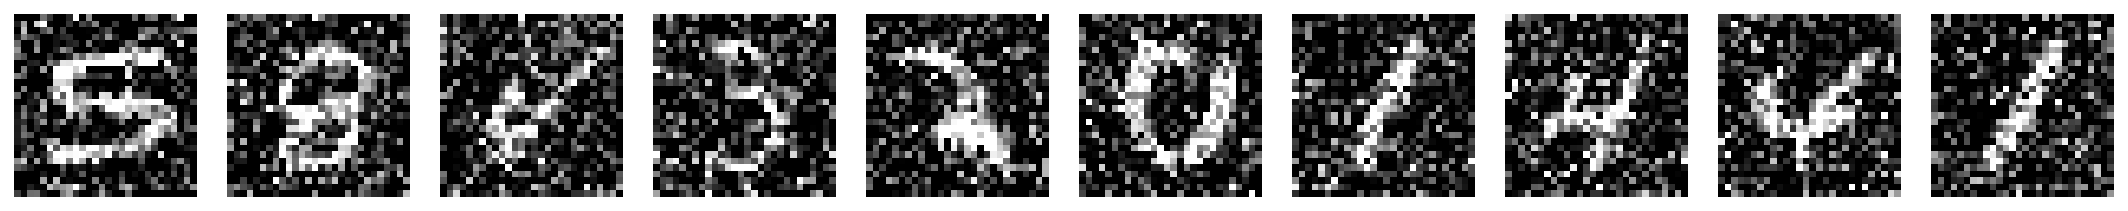

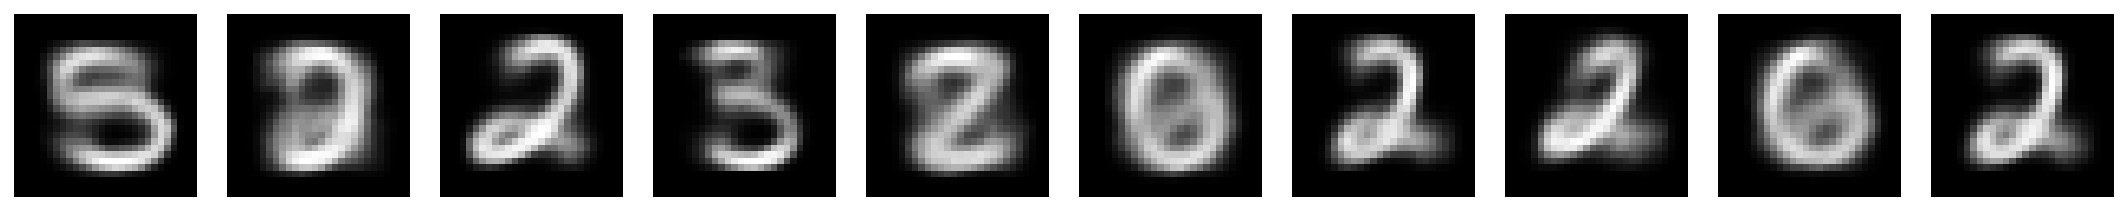

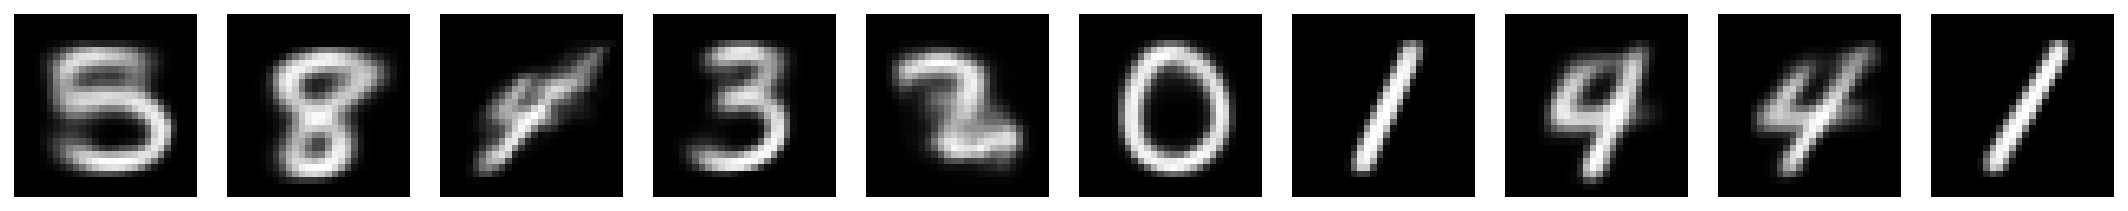

In [11]:
with torch.no_grad():
  output_test_noisy = model(input_test_noisy)
  latent_test_noisy = encoder(input_test_noisy)
  output_test = model(input_test)

plot_row([input_test_noisy[test_selected_idx],
          output_test_noisy[test_selected_idx],
          output_test[test_selected_idx]], image_shape=image_shape)

### Latent space before re-train
We now investigate the origin of reconstruction errors by looking at how adding noise to input samples affects the latent space. Changes in latent space coordinates are picked up by the decoder and reproduced as different digits.

We select the same samples from the row plots and represent them in two latent space maps. The plot on the left represents the original samples (without noise), and the right plot shows location shifts due to noise.

**Instructions**
* Please execute the cell below

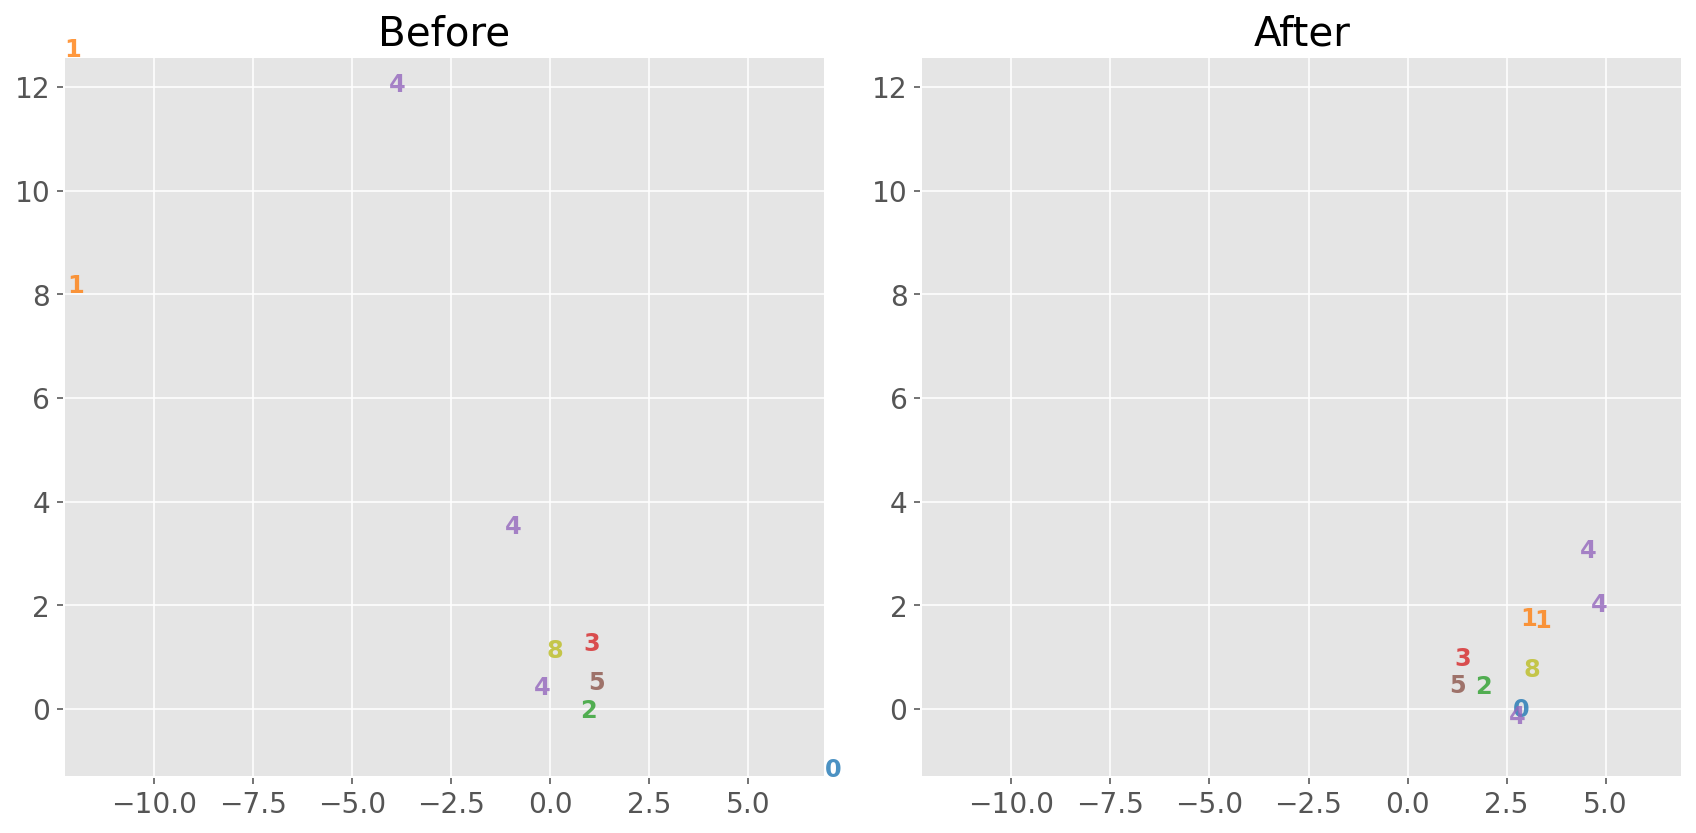

In [12]:
plot_latent_ab(latent_test, latent_test_noisy, y_test, test_selected_idx, s2=s2)

### Re-train the autoencoder with noisy images
Let's re-train the autoencoder with noisy images on the input and clean images on the output, and generate the previous plots with the updated model.

We now see that both noisy and clean images match similar locations in latent space. The network denoises the input by having a representation in latent space that is robust or invariant to noise.

**Instructions**
* Please execute the cell(s) below

Epoch 	 Loss train 	 Loss test
1/10	 0.1942		 0.1946
2/10	 0.1885		 0.1892
3/10	 0.1842		 0.1859
4/10	 0.1831		 0.1848
5/10	 0.1808		 0.1821
6/10	 0.1845		 0.1860
7/10	 0.1810		 0.1830
8/10	 0.1787		 0.1814
9/10	 0.1787		 0.1813
10/10	 0.1773		 0.1805

mse	 0.0385		 0.0395
bce	 0.1773		 0.1805


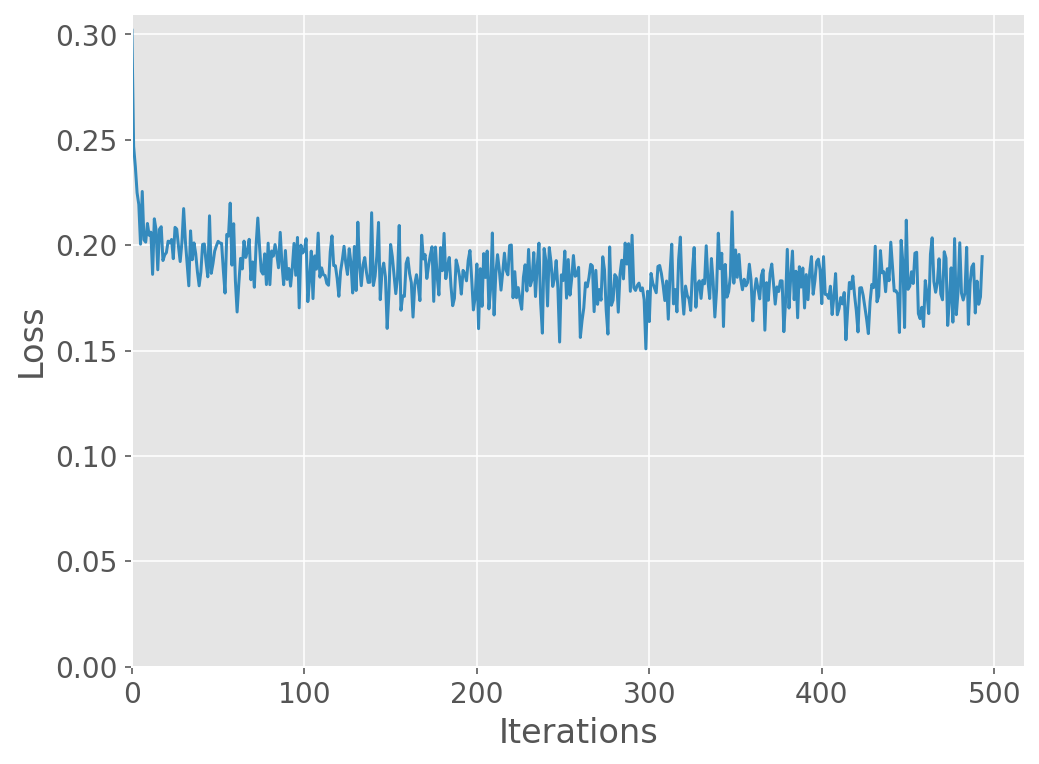

In [13]:
n_epochs = 10
batch_size = 32

model.train()

runSGD(model, input_train_noisy, input_test_noisy, 
       out_train=input_train, out_test=input_test,
       n_epochs=n_epochs, batch_size=batch_size)

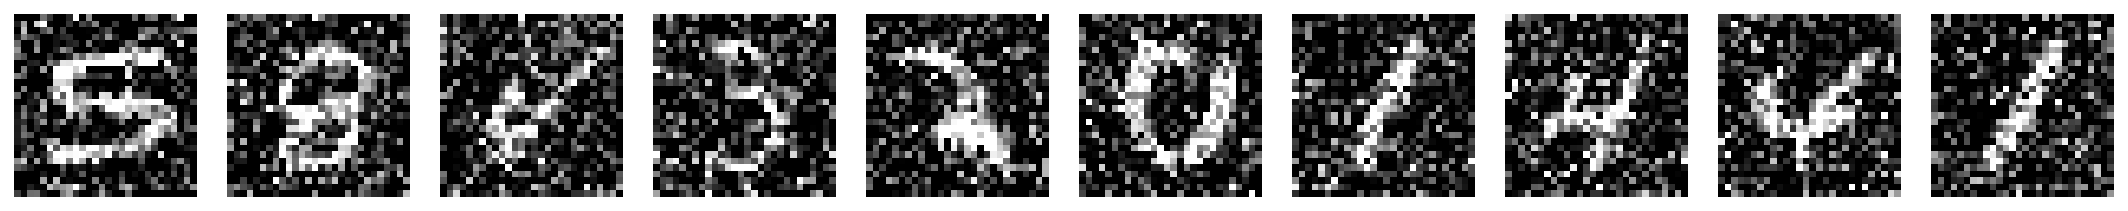

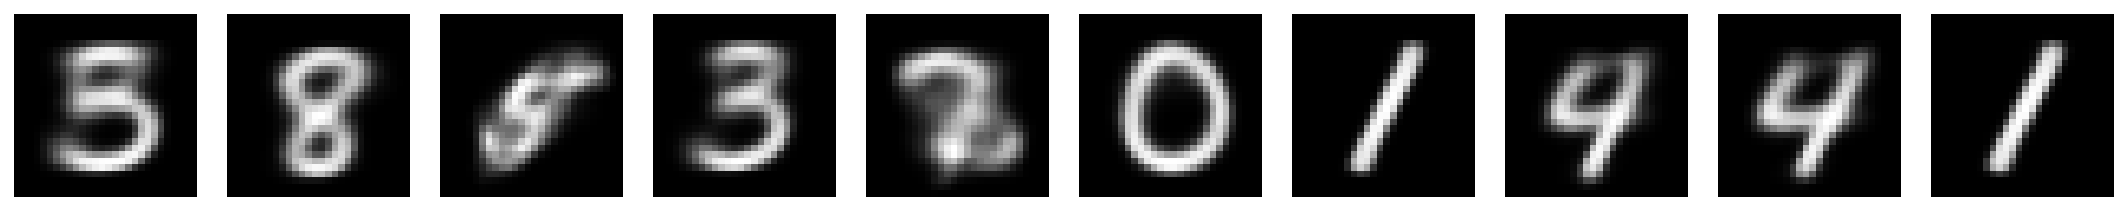

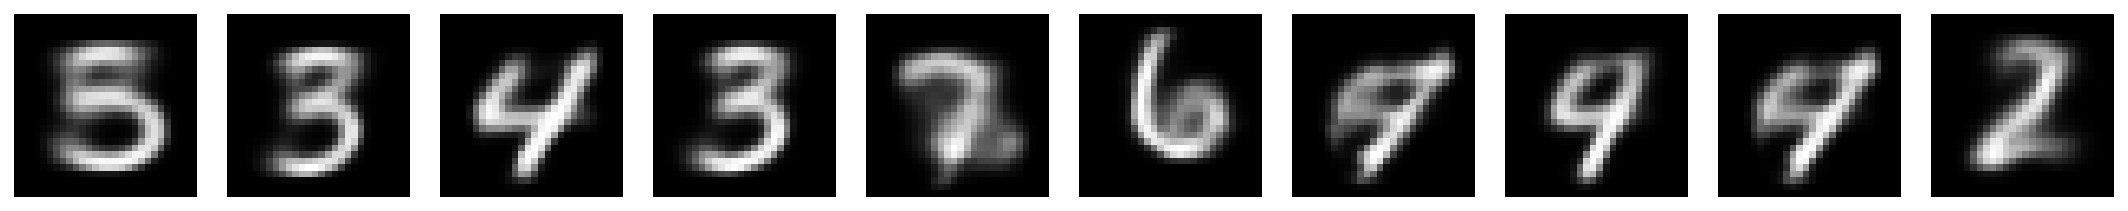

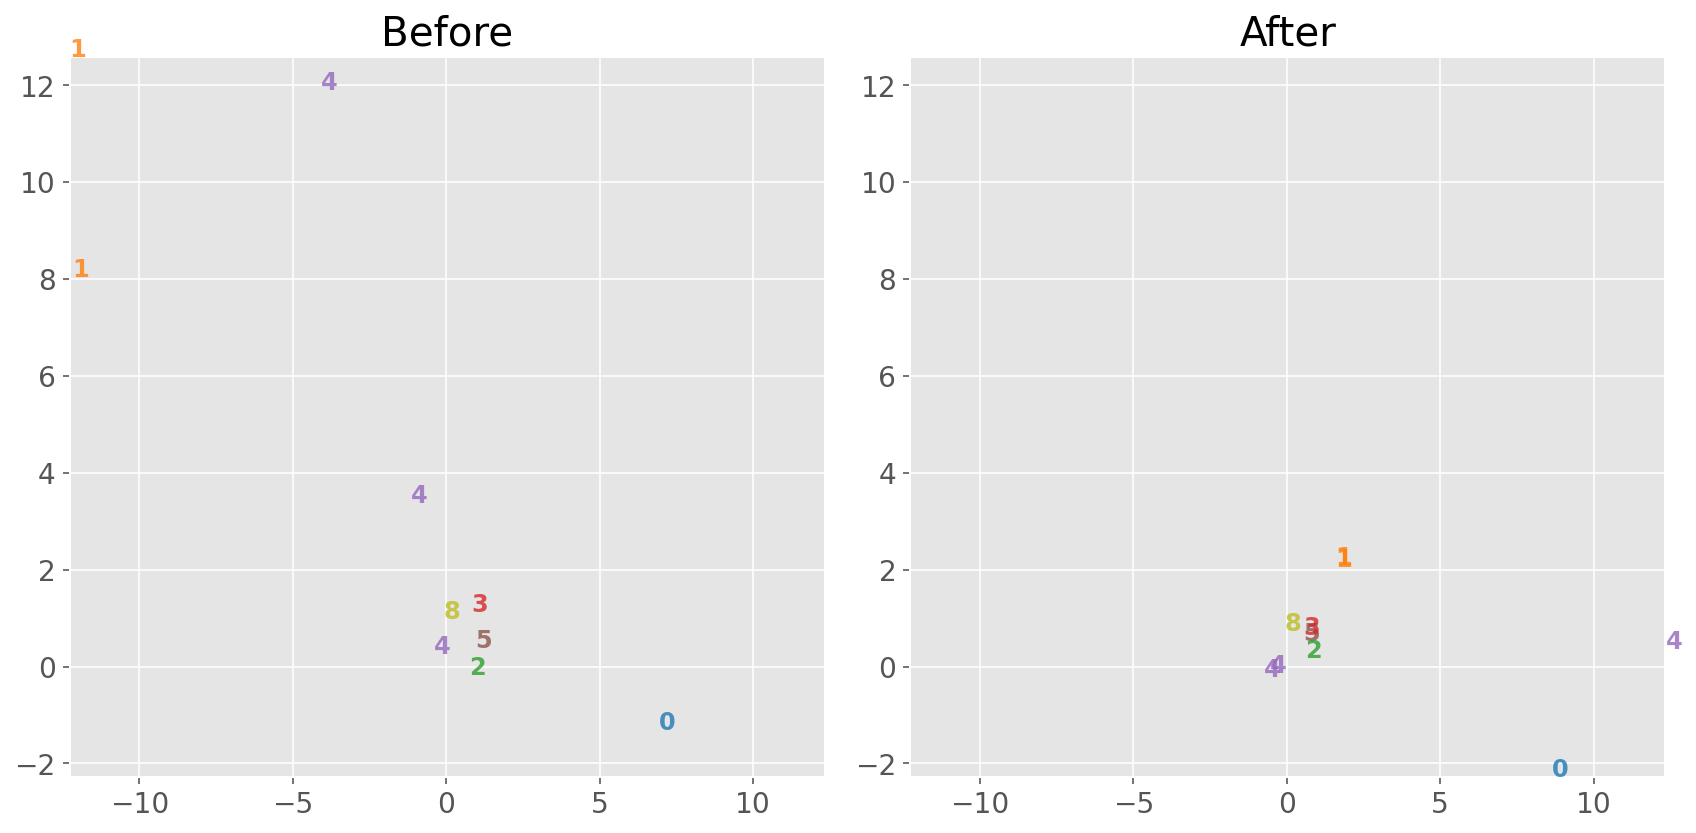

In [14]:
with torch.no_grad():
  output_test_noisy = model(input_test_noisy)
  latent_test_noisy = encoder(input_test_noisy)
  output_test = model(input_test)

plot_row([input_test_noisy[test_selected_idx],
          output_test_noisy[test_selected_idx],
          output_test[test_selected_idx]], image_shape=image_shape)

plot_latent_ab(latent_test, latent_test_noisy, y_test, test_selected_idx, s2=s2)


### Global latent space shift
The new latent space representation is robust to noise and may result in a better internal representation of the dataset. We verify this by inspecting the latent space with clean images before and after re-training with noisy images.

Re-training the network with noisy images causes a *domain shift*, i.e., a change in the distribution of images in the dataset that initially only had clean images. Depending on the task and the extent of changes during re-training,  (number of epochs, optimizer characteristics, etc.), the new latent space representation may be worse for original data but certainly improved for the new data domain. How could we address *domain shift* and improve for both noisy and clean images?

**Instructions**
* Please execute the cell(s) below

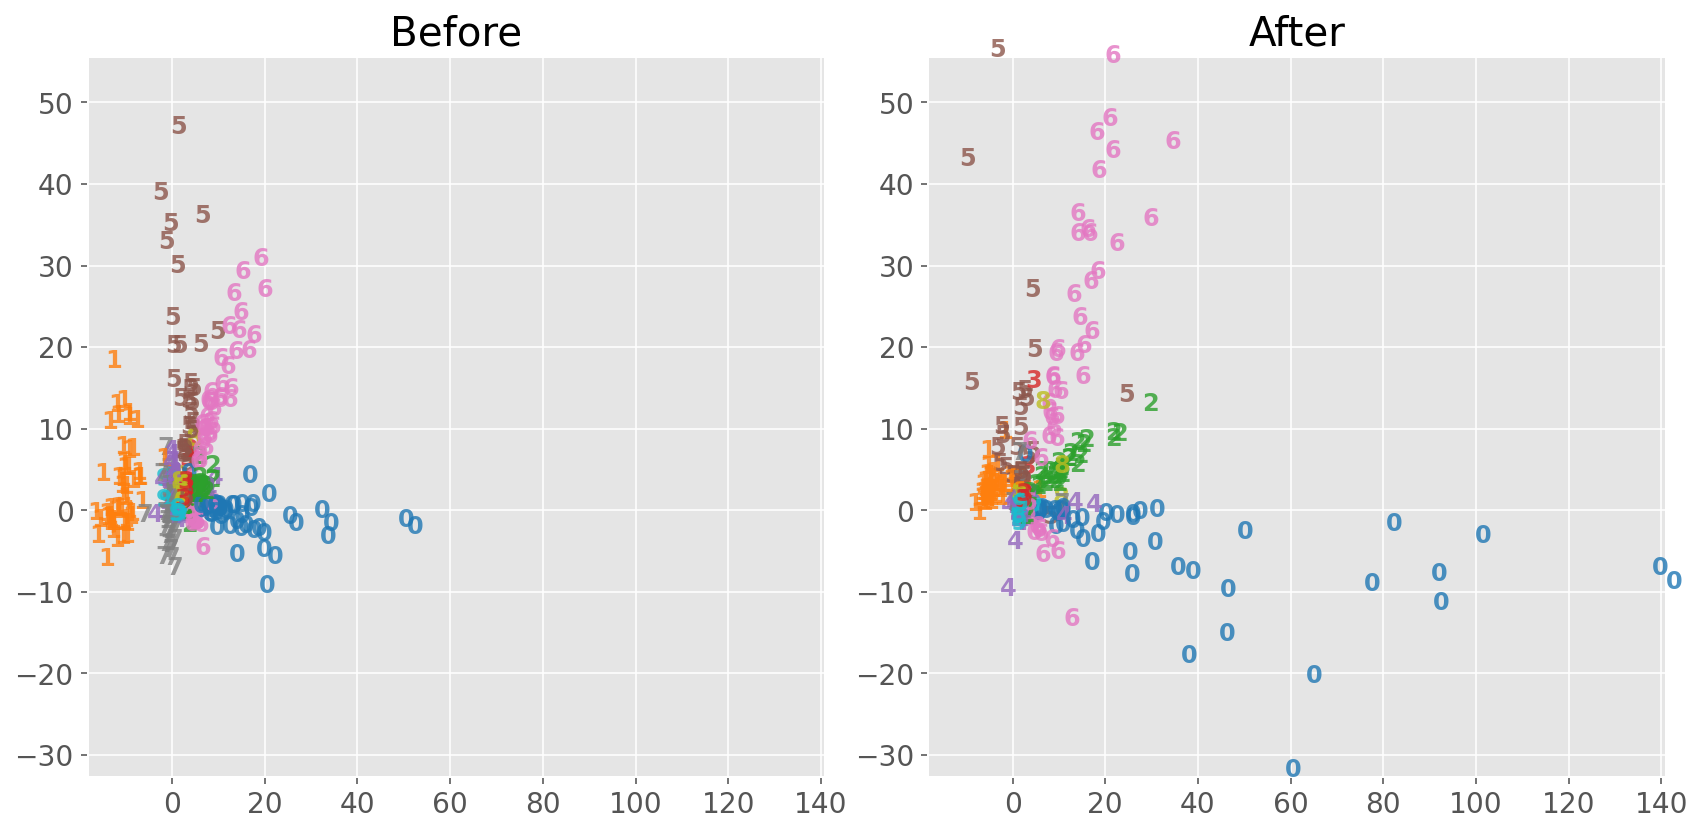

In [15]:
with torch.no_grad():
  latent_test = encoder(input_test)

plot_latent_ab(latent_test_ref, latent_test, y_test, selected_idx, s2=s2)

## Application 2: Image completion
As in the previous exercise, autoencoders cannot reconstruct partial images if the train set does not contain them. Similarly, we investigate the source of this issue by looking at the representation of partial images in latent space and how it adjusts after training.

**Instructions**
* Please execute the cell(s) below

In [16]:
reset_checkpoint(model, optimizer, checkpoint)

with torch.no_grad():
  latent_test_ref = encoder(input_test)

### Before re-train
**Instructions**
* Please execute the cell(s) below

In [17]:
input_train_mask = image_occlusion(input_train, image_shape=image_shape)
input_test_mask = image_occlusion(input_test, image_shape=image_shape)

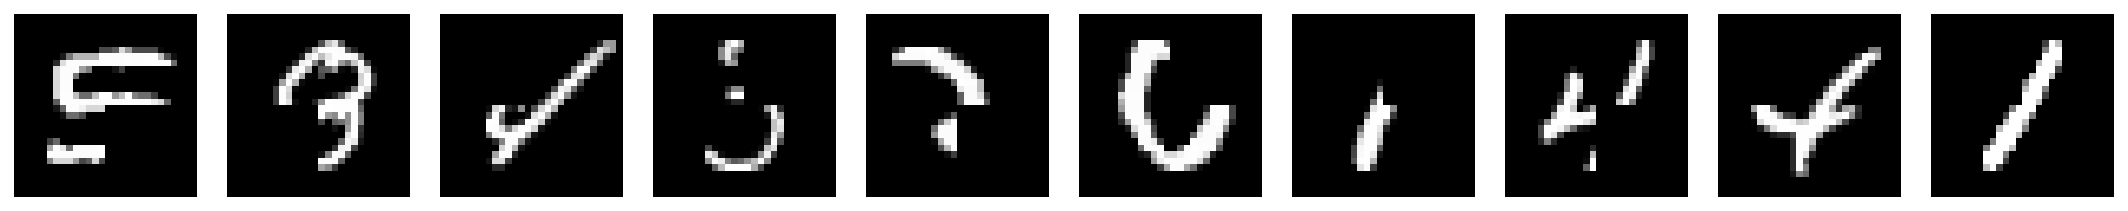

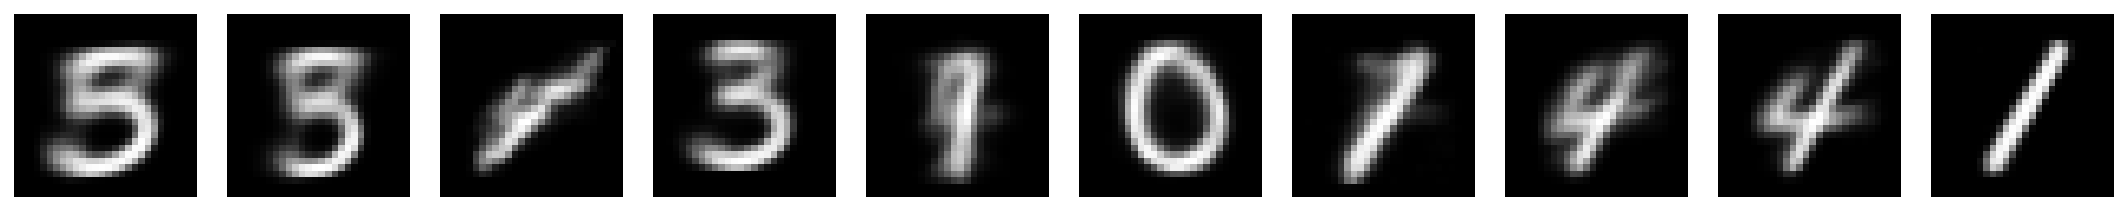

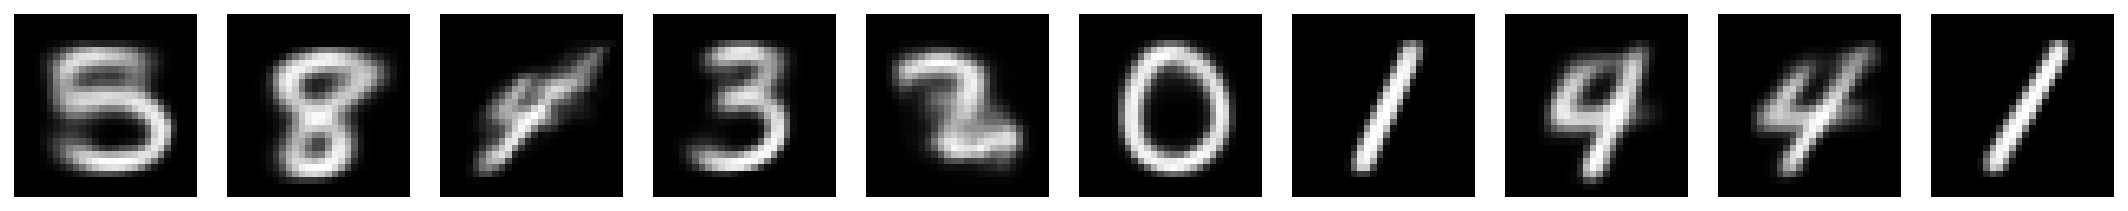

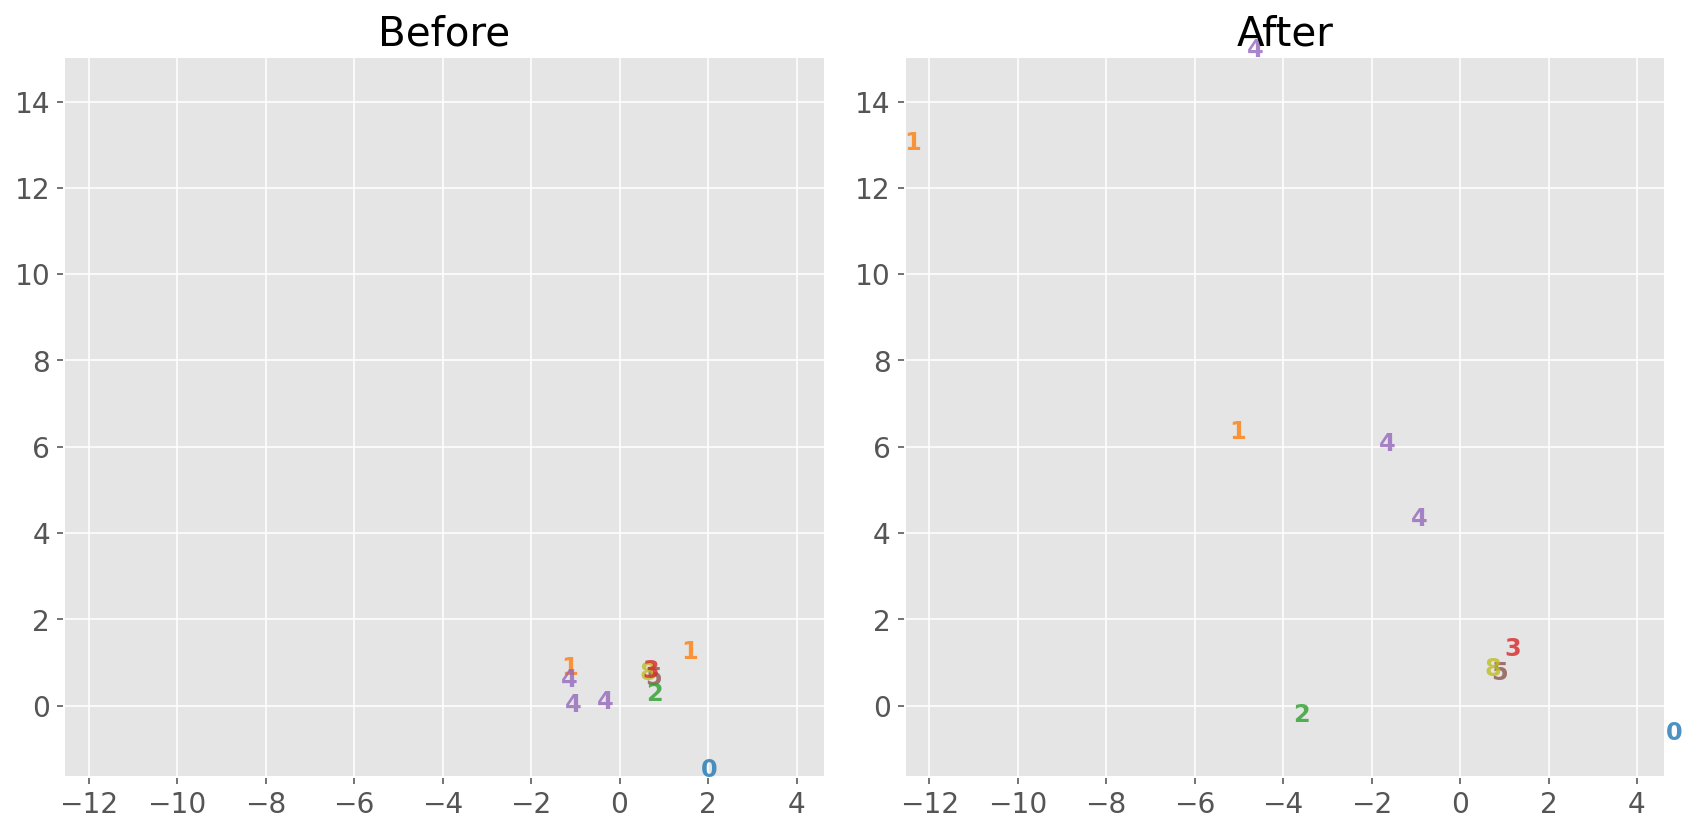

In [18]:
with torch.no_grad():
  output_test_mask = model(input_test_mask)
  latent_test_mask = encoder(input_test_mask)
  output_test = model(input_test)

plot_row([input_test_mask[test_selected_idx],
          output_test_mask[test_selected_idx],
          output_test[test_selected_idx]], image_shape=image_shape)

plot_latent_ab(latent_test, latent_test_mask, y_test, test_selected_idx, s2=s2)

### After re-train

Epoch 	 Loss train 	 Loss test
1/10	 0.1741		 0.1765
2/10	 0.1720		 0.1749
3/10	 0.1723		 0.1752
4/10	 0.1711		 0.1741
5/10	 0.1705		 0.1739
6/10	 0.1702		 0.1738
7/10	 0.1694		 0.1737
8/10	 0.1706		 0.1747
9/10	 0.1691		 0.1735
10/10	 0.1698		 0.1745

mse	 0.0361		 0.0376
bce	 0.1698		 0.1745


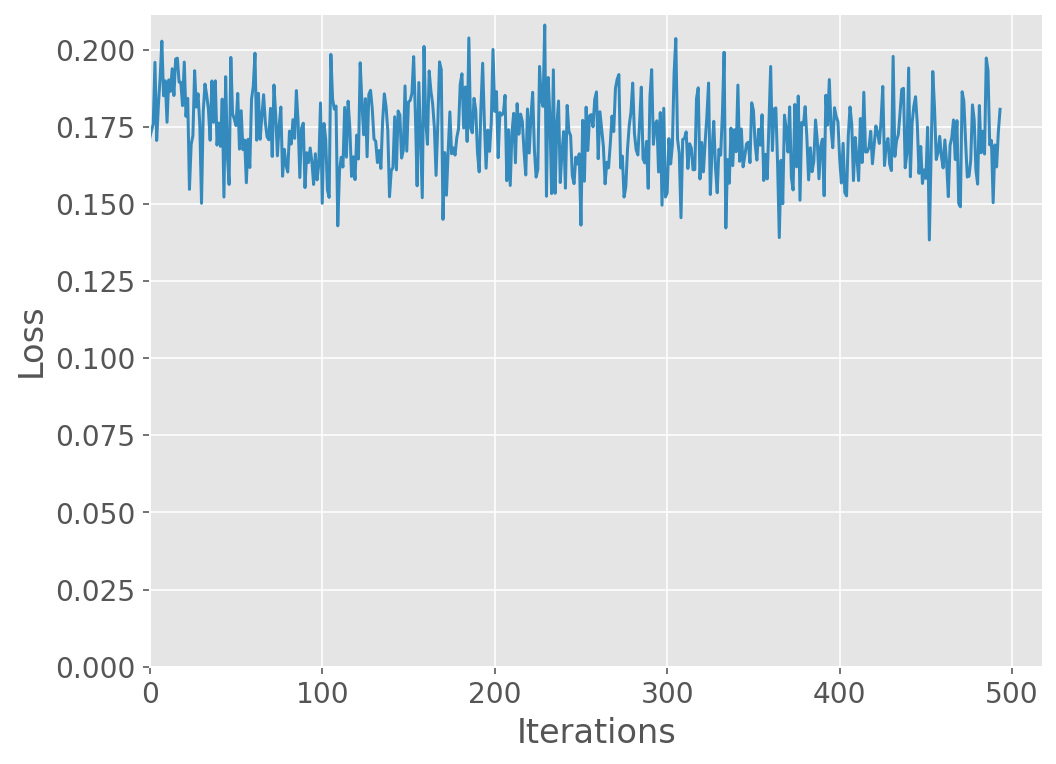

In [19]:
n_epochs = 10
batch_size = 32

model.train()

runSGD(model, input_train_mask, input_test_mask, 
       out_train=input_train, out_test=input_test,
       n_epochs=n_epochs, batch_size=batch_size)

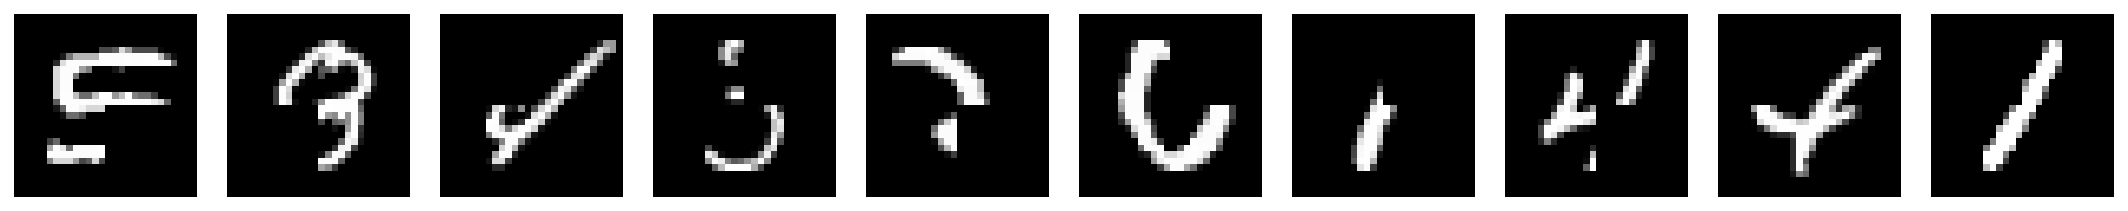

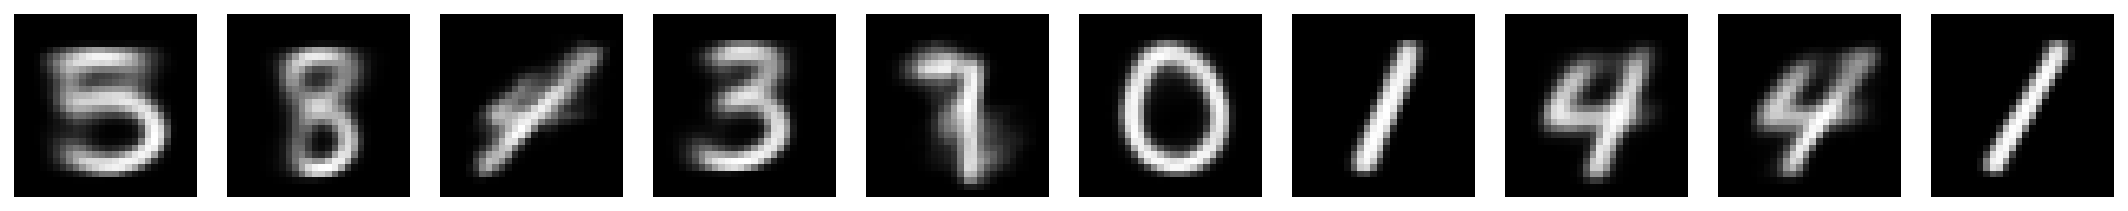

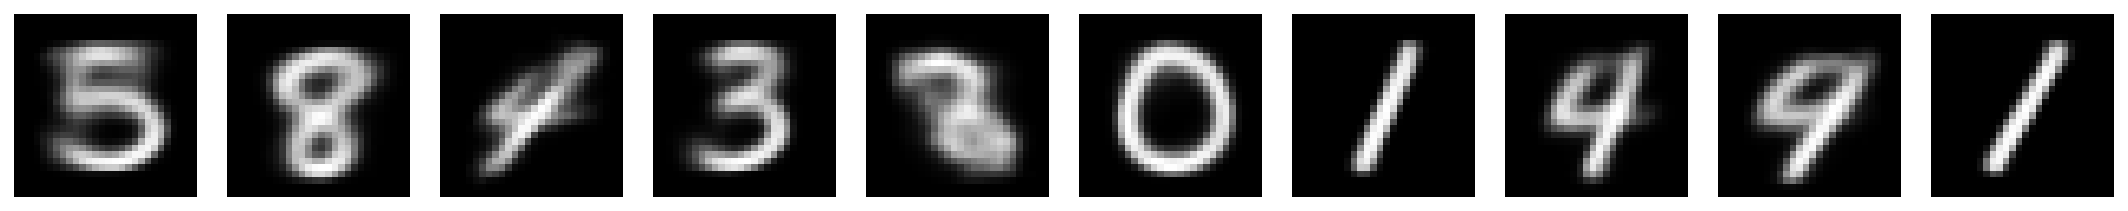

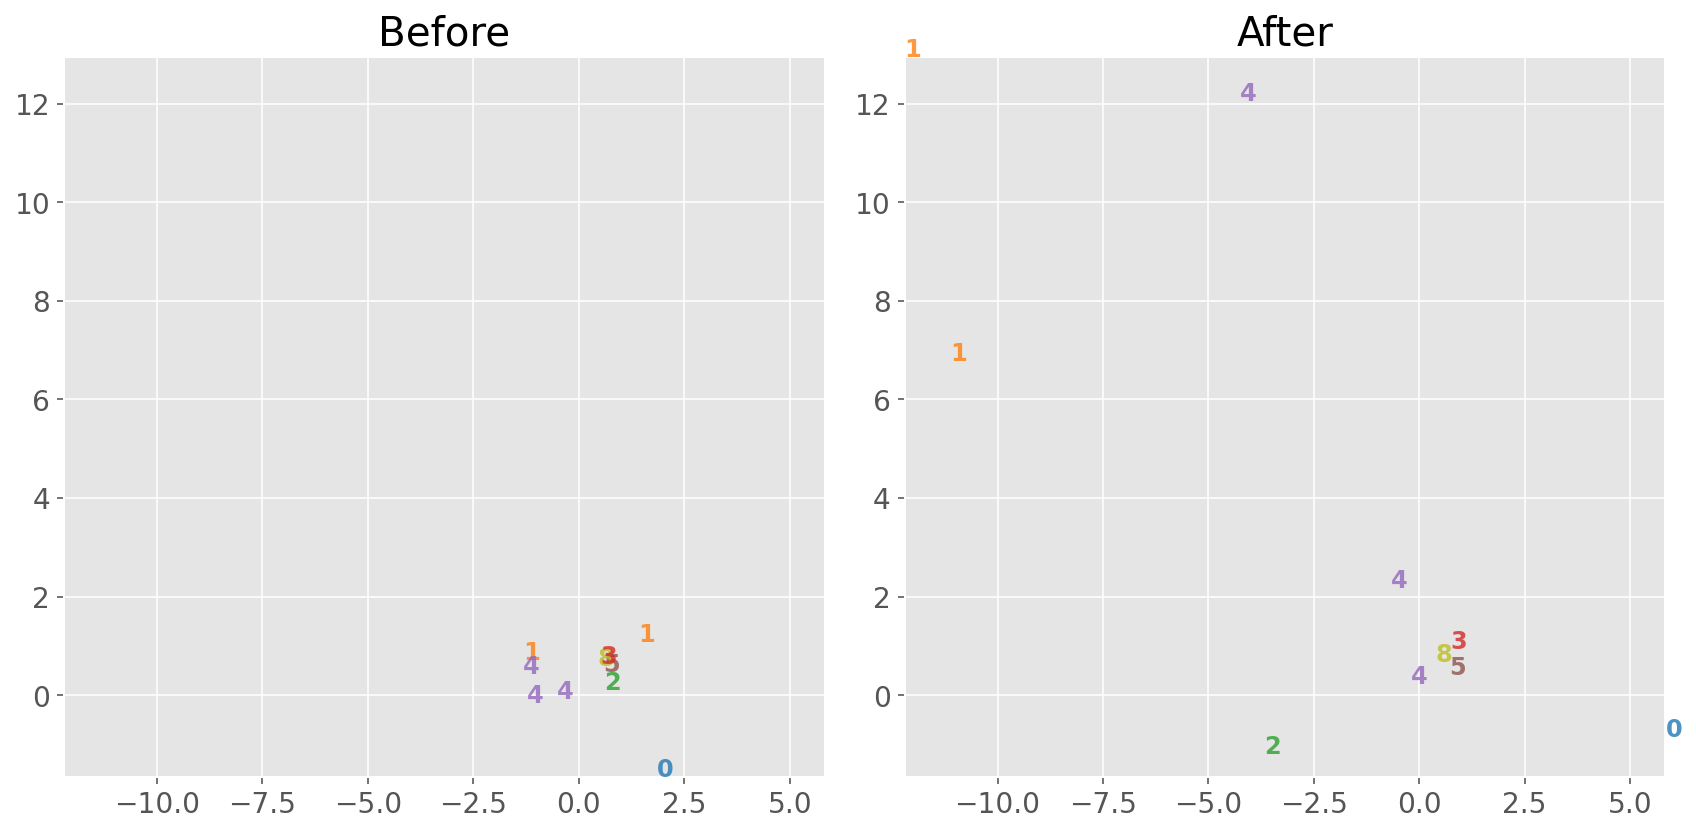

In [20]:
with torch.no_grad():
  output_test_mask = model(input_test_mask)
  latent_test_mask = encoder(input_test_mask)
  output_test = model(input_test)

plot_row([input_test_mask[test_selected_idx],
          output_test_mask[test_selected_idx],
          output_test[test_selected_idx]], image_shape=image_shape)

plot_latent_ab(latent_test, latent_test_mask, y_test, test_selected_idx, s2=s2)

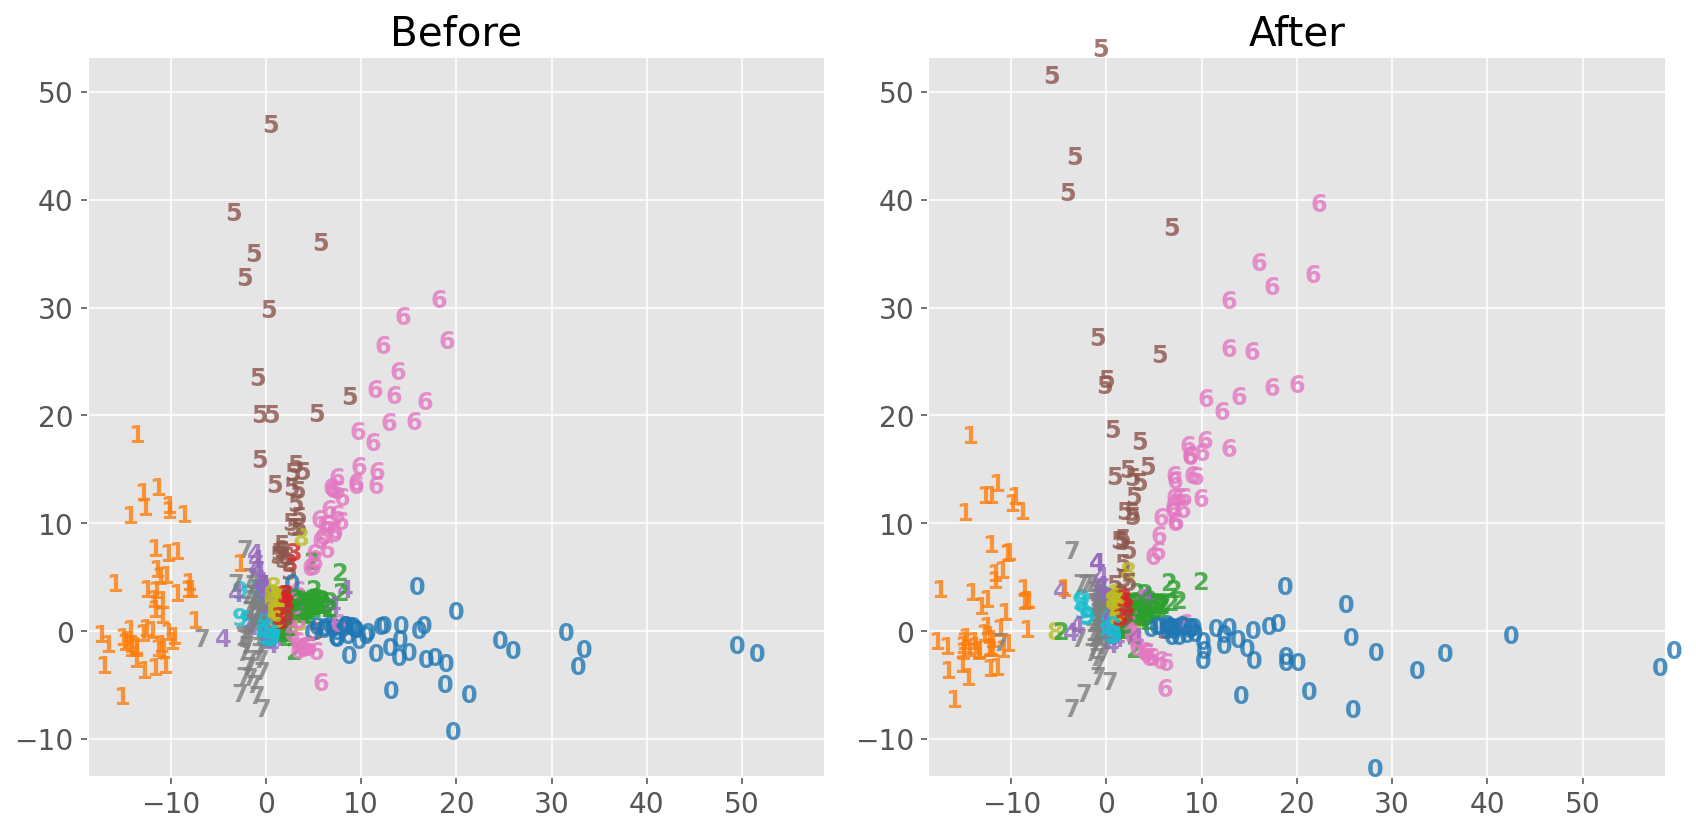

In [21]:
with torch.no_grad():
  latent_test = encoder(input_test)

plot_latent_ab(latent_test_ref, latent_test, y_test, selected_idx, s2=s2)

## Application 3: Image rotation
Another example in line with the previous ones is the representation of rotated images.

**Instructions**
* Please execute the cell(s) below

In [22]:
reset_checkpoint(model, optimizer, checkpoint)

with torch.no_grad():
  latent_test_ref = encoder(input_test)

### Before re-train
**Instructions**
* Please execute the cell(s) below

In [23]:
input_train_rotation = image_rotation(input_train, 90, image_shape=image_shape)
input_test_rotation = image_rotation(input_test, 90, image_shape=image_shape)

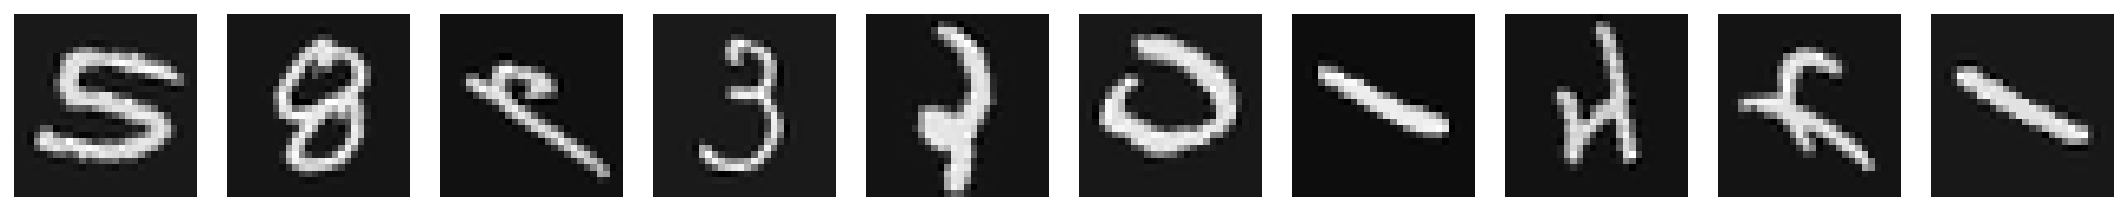

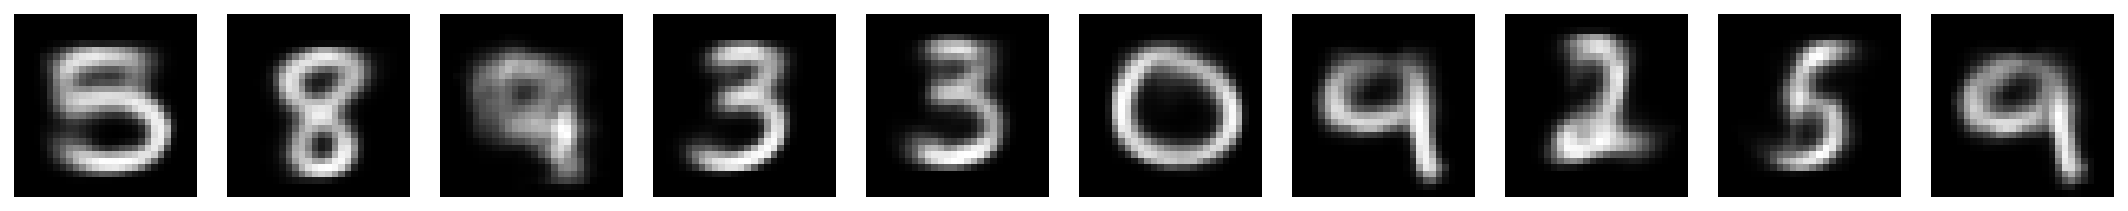

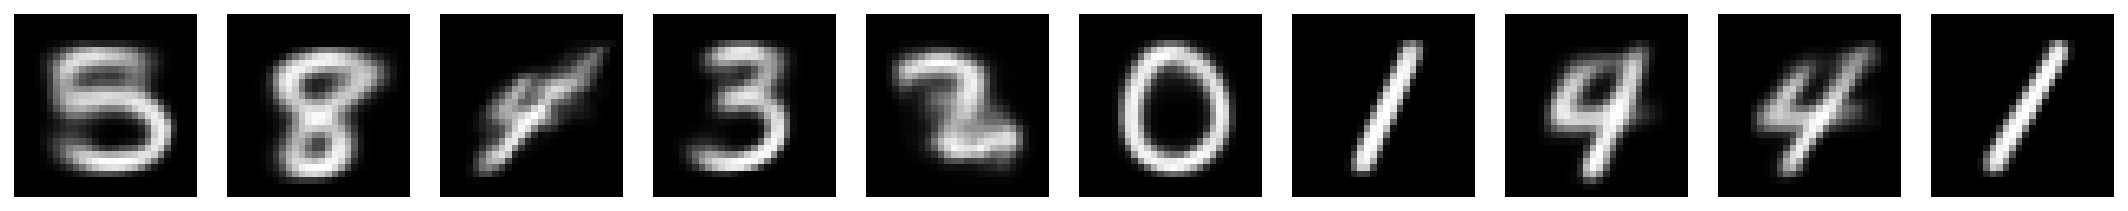

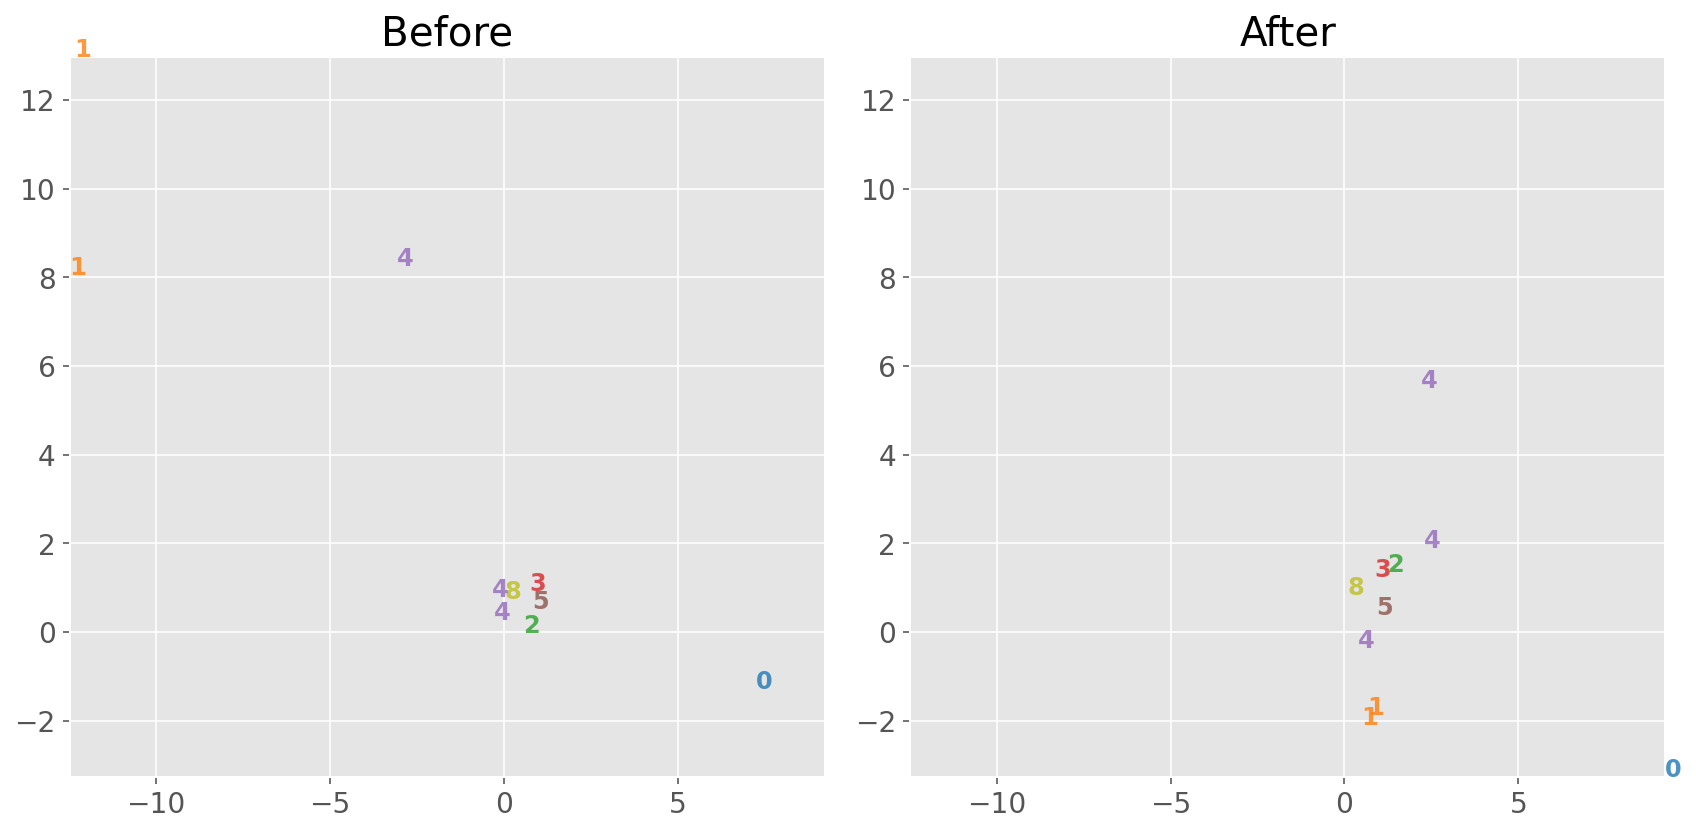

In [24]:
with torch.no_grad():
  output_test_rotation = model(input_test_rotation)
  latent_test_rotation = encoder(input_test_rotation)
  output_test = model(input_test)

plot_row([input_test_rotation[test_selected_idx],
          output_test_rotation[test_selected_idx],
          output_test[test_selected_idx]], image_shape=image_shape)

plot_latent_ab(latent_test, latent_test_rotation, y_test, test_selected_idx, s2=s2)

### After re-train
**Instructions**
* Please execute the cell(s) below

Epoch 	 Loss train 	 Loss test
1/10	 0.2156		 0.2162
2/10	 0.2092		 0.2102
3/10	 0.2049		 0.2063
4/10	 0.2022		 0.2037
5/10	 0.2002		 0.2025
6/10	 0.1985		 0.2013
7/10	 0.1970		 0.1994
8/10	 0.1966		 0.1991
9/10	 0.1958		 0.1987
10/10	 0.1948		 0.1981

mse	 0.0446		 0.0456
bce	 0.1948		 0.1981


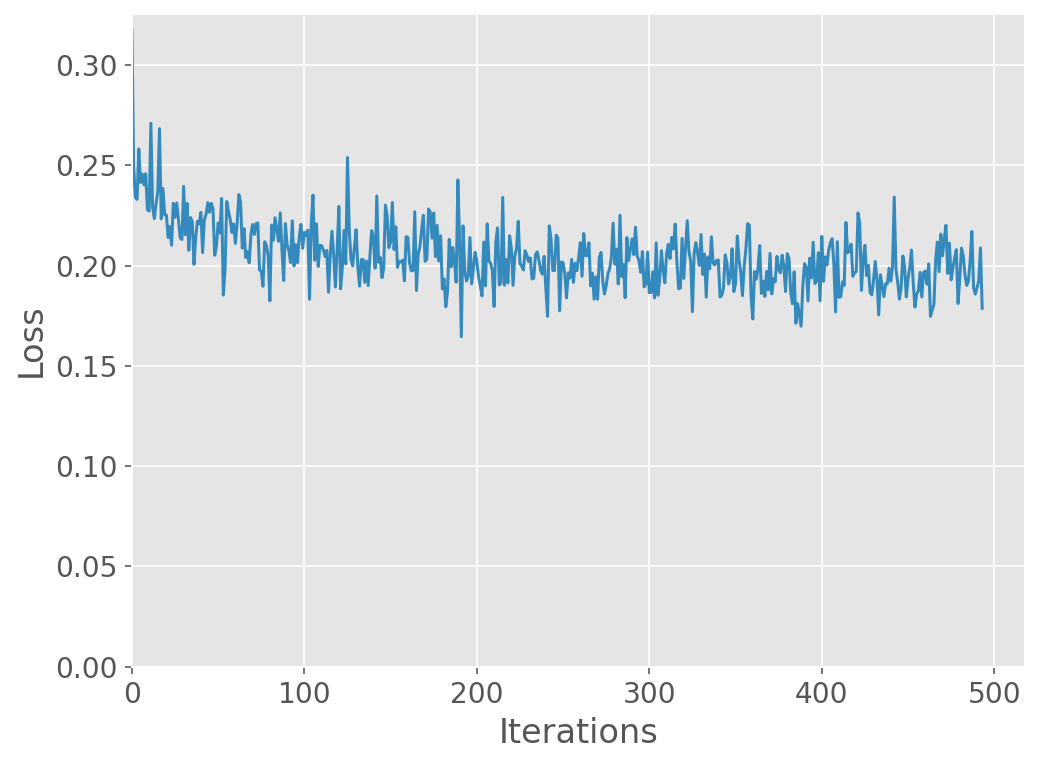

In [25]:
n_epochs = 10
batch_size = 32

model.train()

runSGD(model, input_train_rotation, input_test_rotation, 
       out_train=input_train, out_test=input_test,
       n_epochs=n_epochs, batch_size=batch_size)

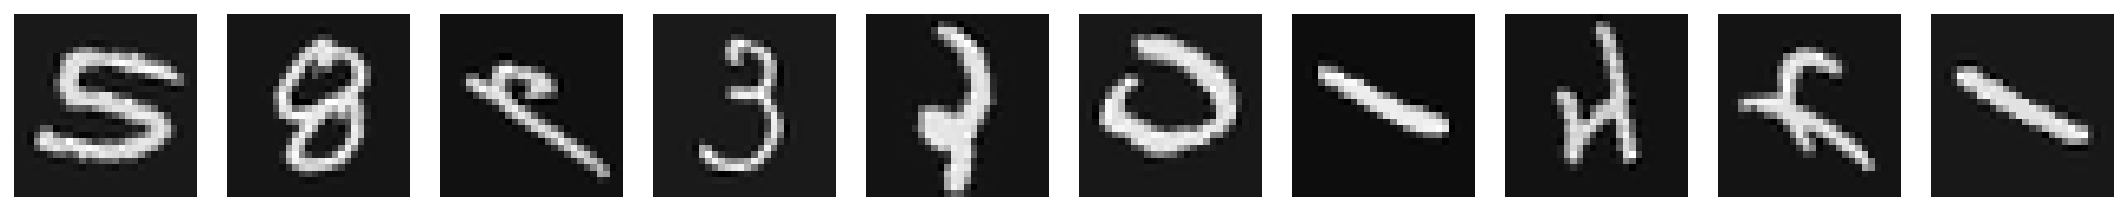

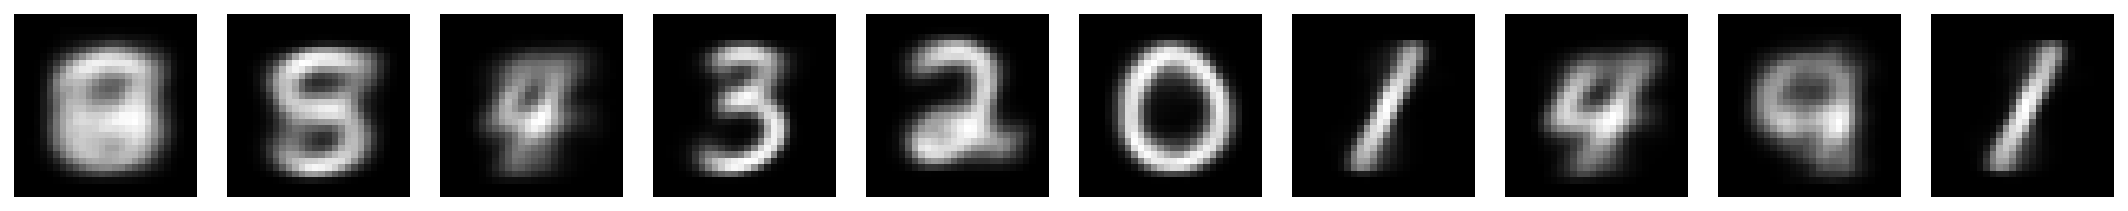

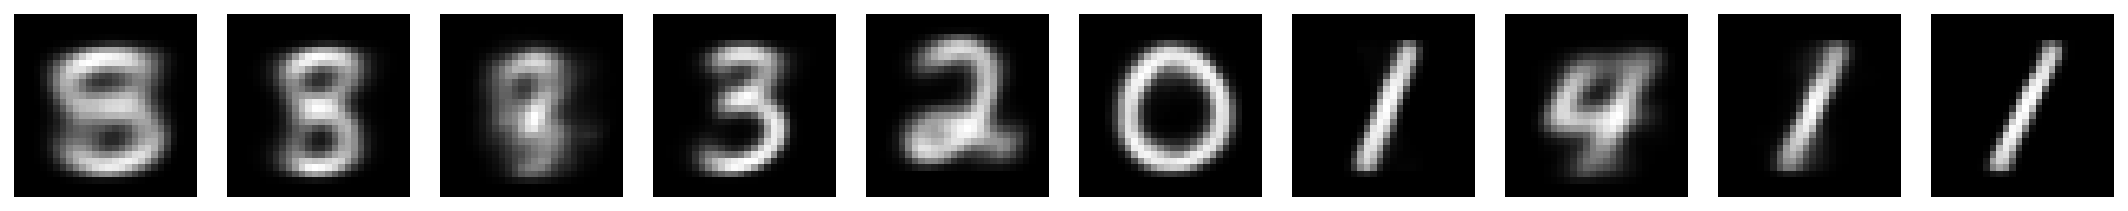

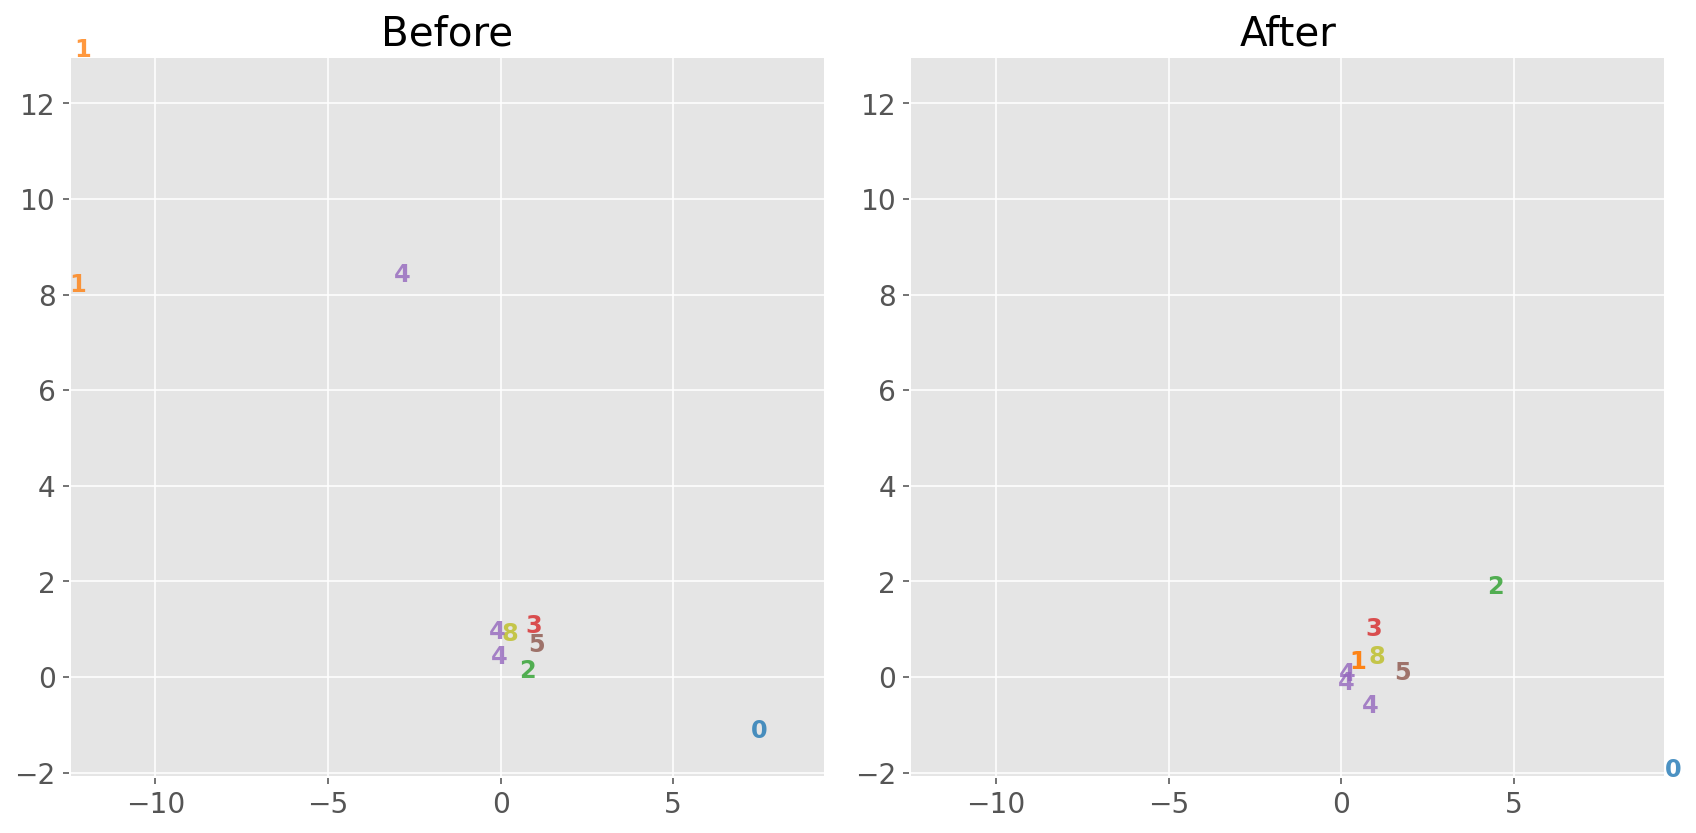

In [26]:
with torch.no_grad():
  output_test_rotation = model(input_test_rotation)
  latent_test_rotation = encoder(input_test_rotation)
  output_test = model(input_test)

plot_row([input_test_rotation[test_selected_idx],
          output_test_rotation[test_selected_idx],
          output_test[test_selected_idx]], image_shape=image_shape)

plot_latent_ab(latent_test, latent_test_rotation, y_test, test_selected_idx, s2=s2)

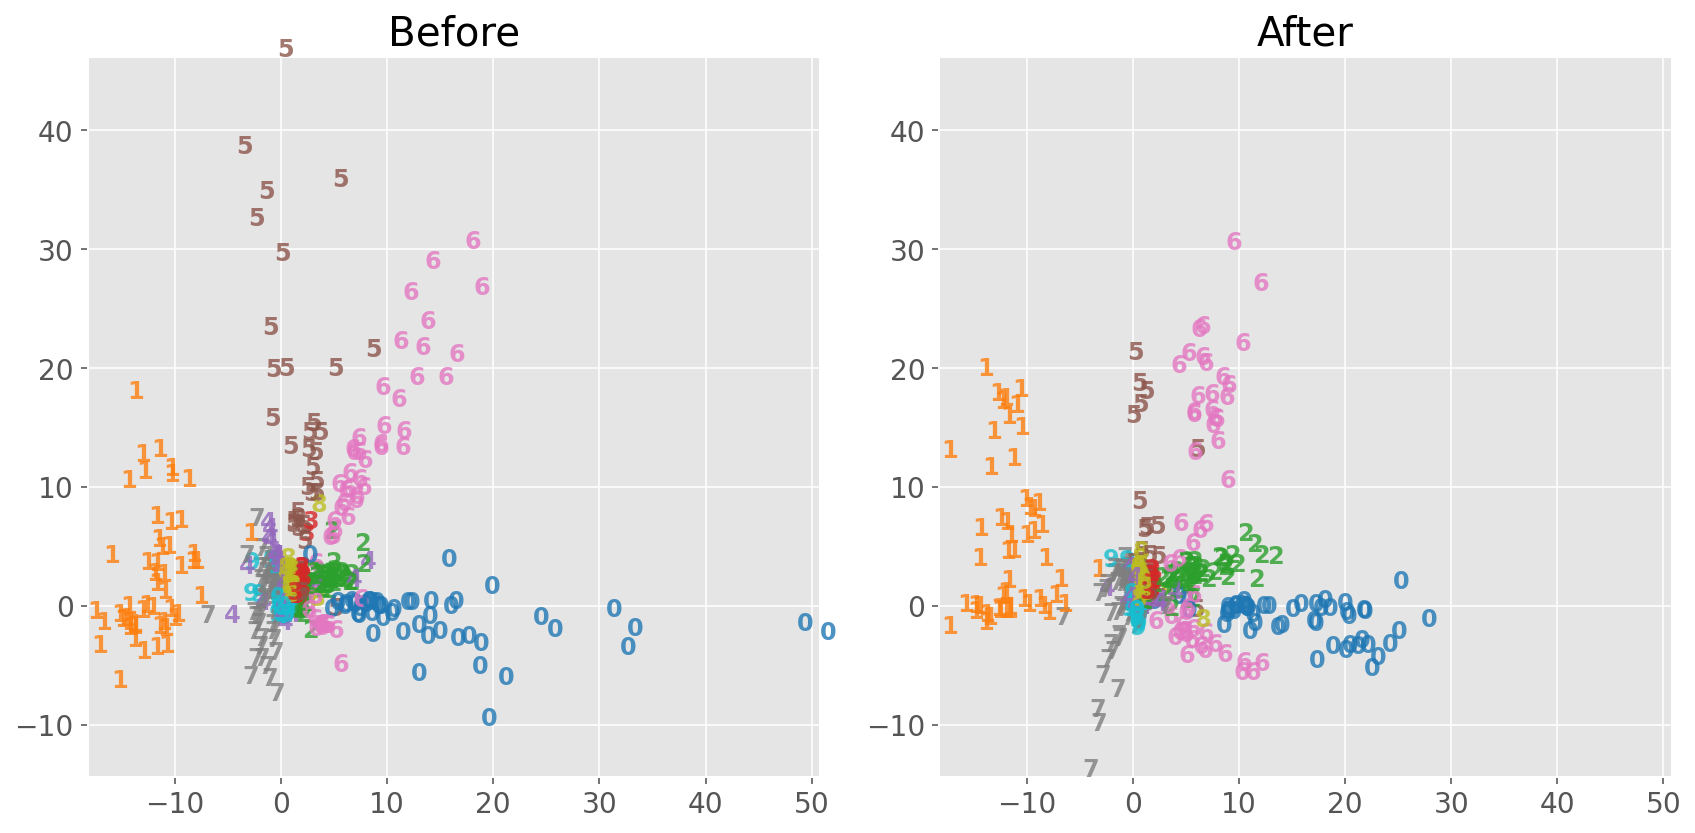

In [27]:
with torch.no_grad():
  latent_test = encoder(input_test)

plot_latent_ab(latent_test_ref, latent_test, y_test, selected_idx, s2=s2)

## What would digit "6" look like if you had never seen it before?
Before we start melting our brains with such an impossible task, let's test it with an autoencoder!

**Instructions**
* Please execute the cell(s) below

In [28]:
model = AutoencoderClass(s2=s2)
optimizer = optim.Adam(model.parameters())

encoder = model.encoder
decoder = model.decoder

In [29]:
missing = 6

my_input_train = input_train[y_train!=missing]
my_input_test = input_test[y_test!=missing]
my_y_test = y_test[y_test!=missing]

Epoch 	 Loss train 	 Loss test
1/2	 0.1895		 0.1889
2/2	 0.1815		 0.1817

mse	 0.0402		 0.0404
bce	 0.1815		 0.1817


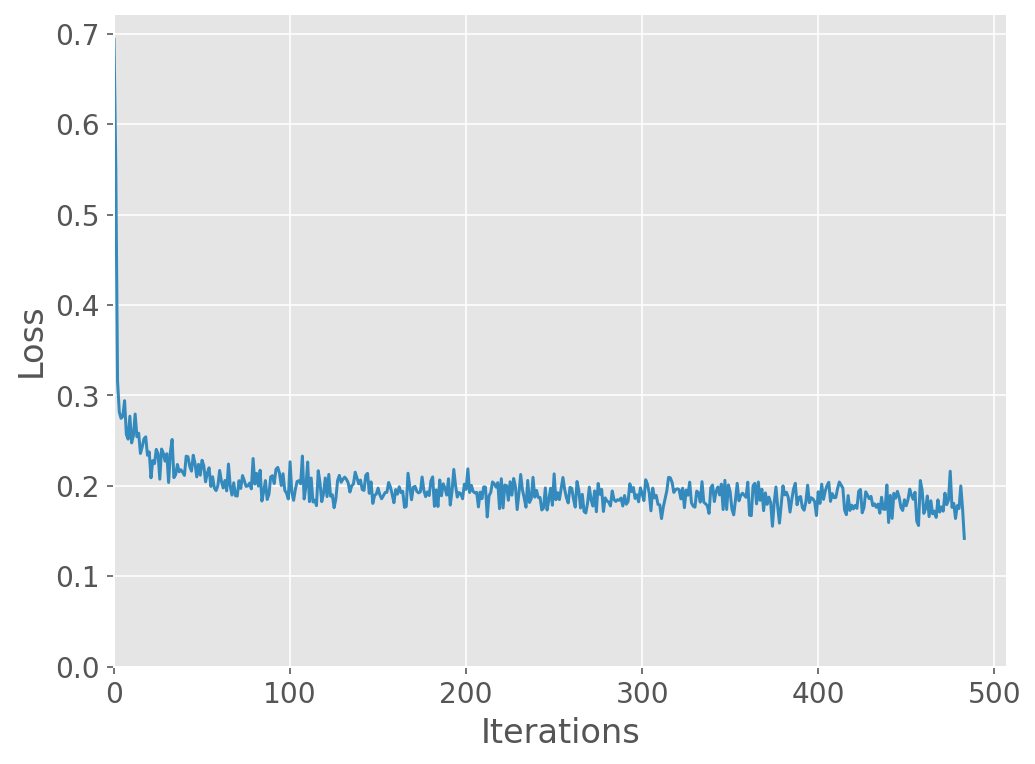

In [30]:
n_epochs = 2
batch_size = 32

runSGD(model, my_input_train, my_input_test, 
       n_epochs=n_epochs, batch_size=batch_size)

with torch.no_grad():
  output_test = model(input_test)
  my_latent_test = encoder(my_input_test)

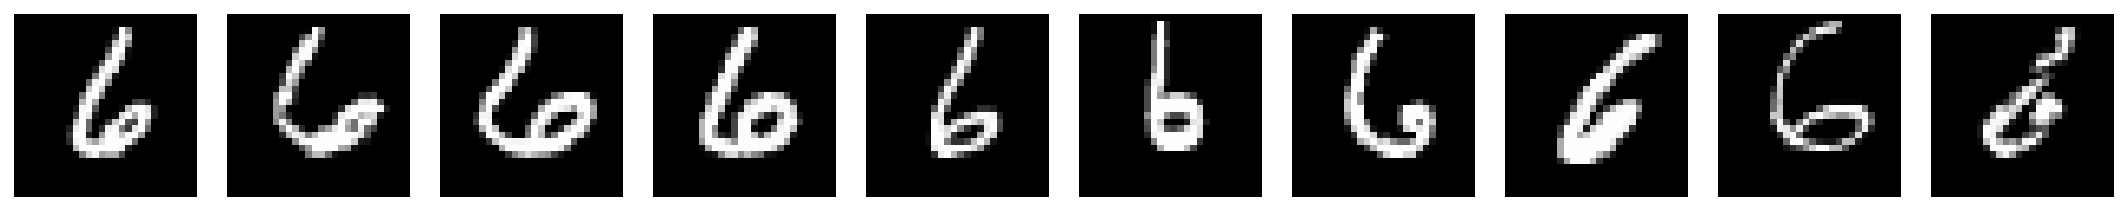

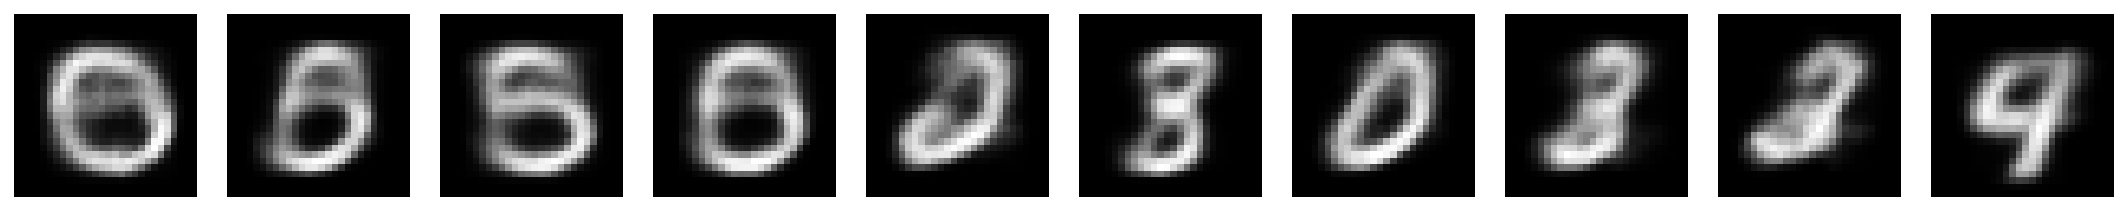

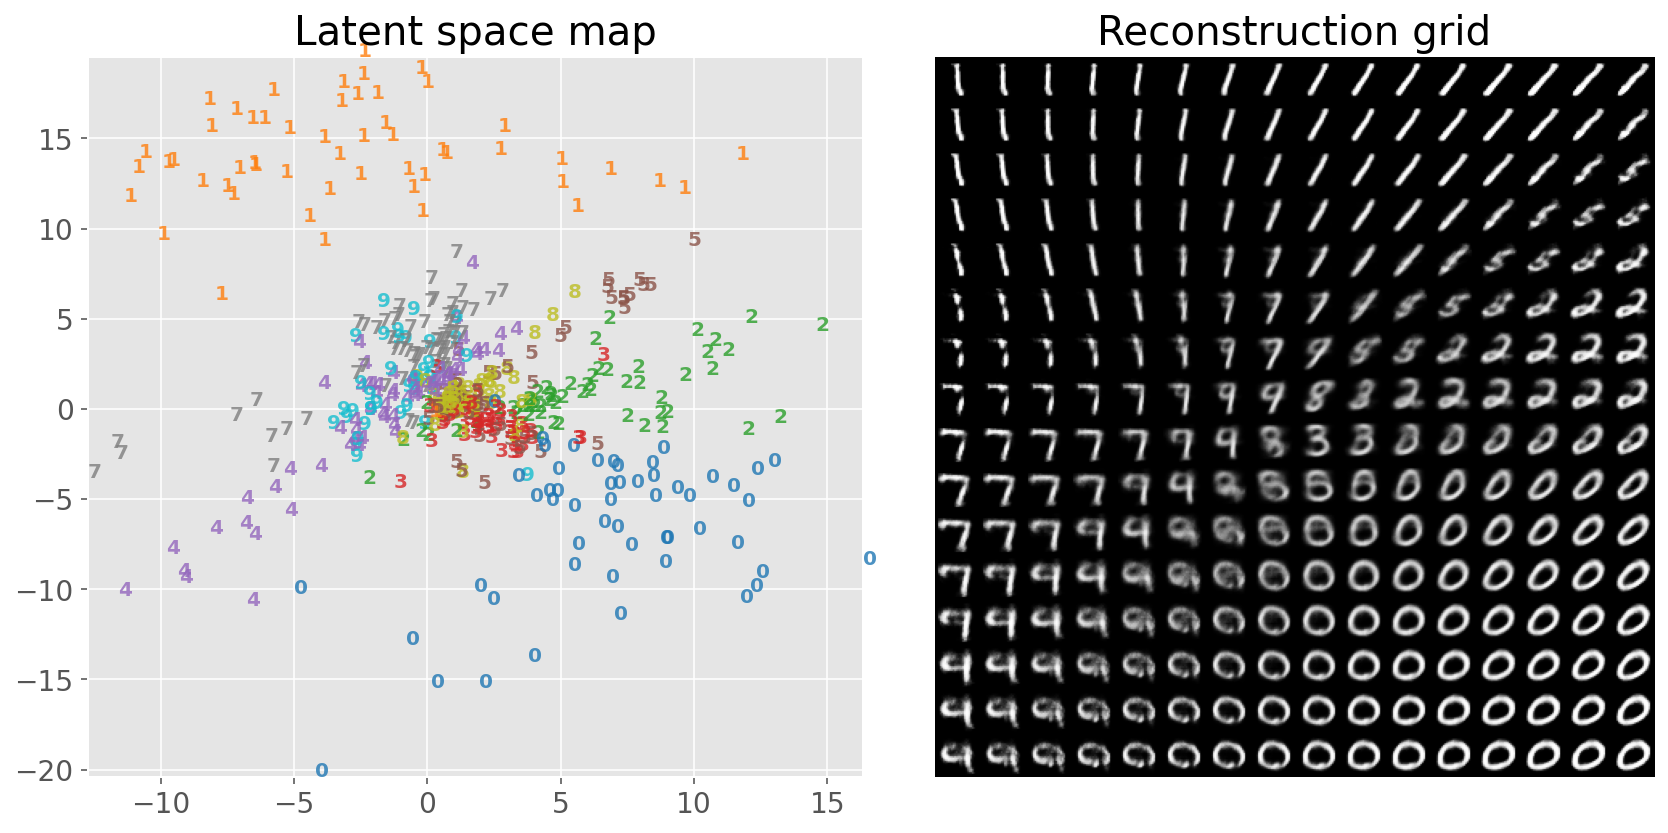

In [31]:
plot_row([input_test[y_test==6], output_test[y_test==6]], image_shape=image_shape)

plot_latent_generative(my_latent_test, my_y_test, decoder, 
                       image_shape=image_shape, s2=s2)

## Exercise 1: How will latent space change when removing the two most discriminative digits?
We've seen that digits `0` and `1` occupy large and opposed areas of the reconstruction grid, i.e., the generative space. On the contrary, other digits occupy very little generative space.

How would you expect latent space to re-arrange after removing these two dominant classes? Would it re-arrange evenly among remaining classes or choose two dominant classes again?

**Suggestions**
* Please execute the cell(s) below
* The intersection of two boolean arrays by condition is specified as `x[(cond_a)&(cond_b)]`

In [32]:
model = AutoencoderClass(s2=s2)
optimizer = optim.Adam(model.parameters())

encoder = model.encoder
decoder = model.decoder

In [33]:
# Exercise 1

missing_a = 1
missing_b = 0

# --> insert your code here

# my_input_train = 
# my_input_test =
# my_y_test = 

# <--

# uncomment below
# print(my_input_train.shape)
# print(my_input_test.shape)
# print(my_y_test.shape)

**SAMPLE OUTPUT**

```
torch.Size([47335, 784])
torch.Size([7885, 784])
torch.Size([7885])
```

In [34]:
# to_remove solution

missing_a = 1
missing_b = 0

my_input_train = input_train[(y_train!=missing_a)&(y_train!=missing_b)]
my_input_test = input_test[(y_test!=missing_a)&(y_test!=missing_b)]
my_y_test = y_test[(y_test!=missing_a)&(y_test!=missing_b)]

print(my_input_train.shape)
print(my_input_test.shape)
print(my_y_test.shape)

torch.Size([47335, 784])
torch.Size([7884, 784])
torch.Size([7884])


Epoch 	 Loss train 	 Loss test
1/10	 0.1996		 0.1996
2/10	 0.1925		 0.1936
3/10	 0.1882		 0.1895
4/10	 0.1863		 0.1881
5/10	 0.1845		 0.1864
6/10	 0.1828		 0.1852
7/10	 0.1812		 0.1837
8/10	 0.1807		 0.1829
9/10	 0.1797		 0.1825
10/10	 0.1797		 0.1825

mse	 0.0389		 0.0398
bce	 0.1797		 0.1825


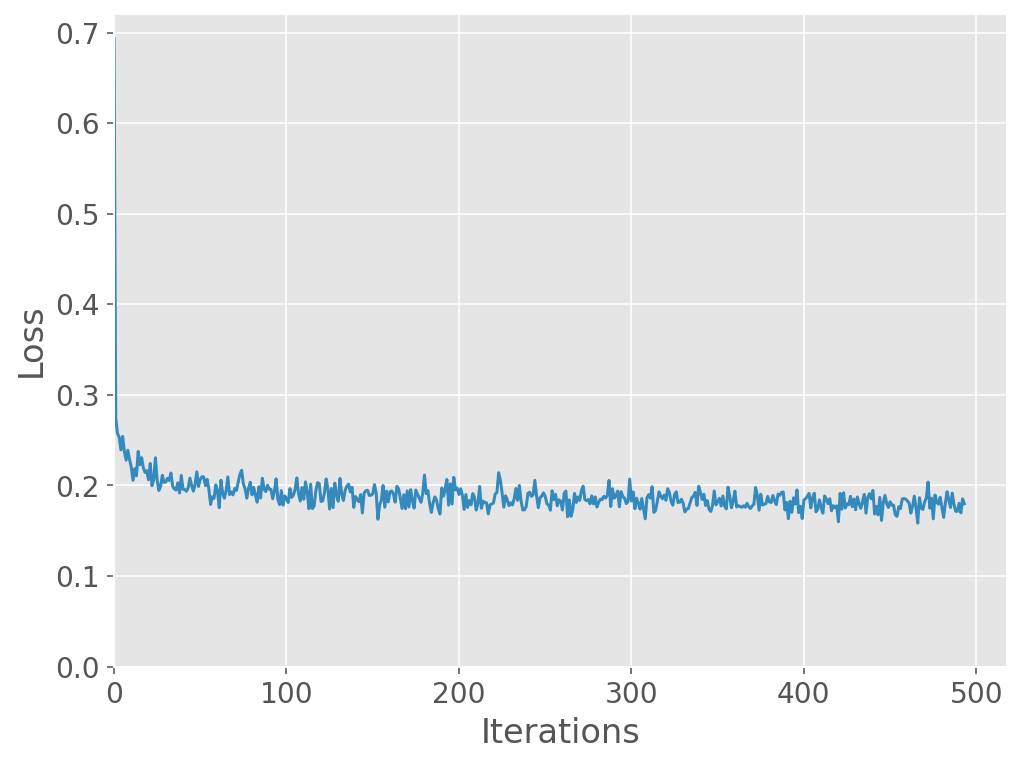

In [35]:
n_epochs = 10
batch_size = 32

runSGD(model, my_input_train, my_input_test, 
       n_epochs=n_epochs, batch_size=batch_size)

with torch.no_grad():
  output_test = model(input_test)
  my_latent_test = encoder(my_input_test)

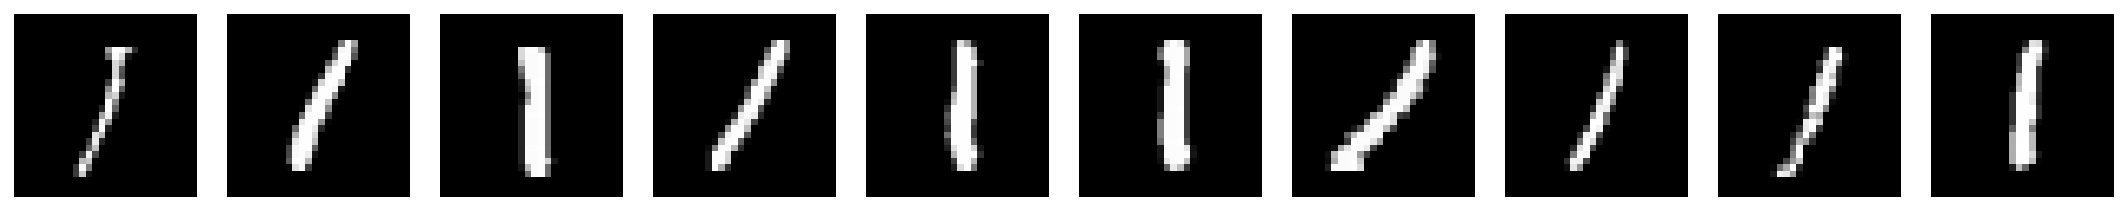

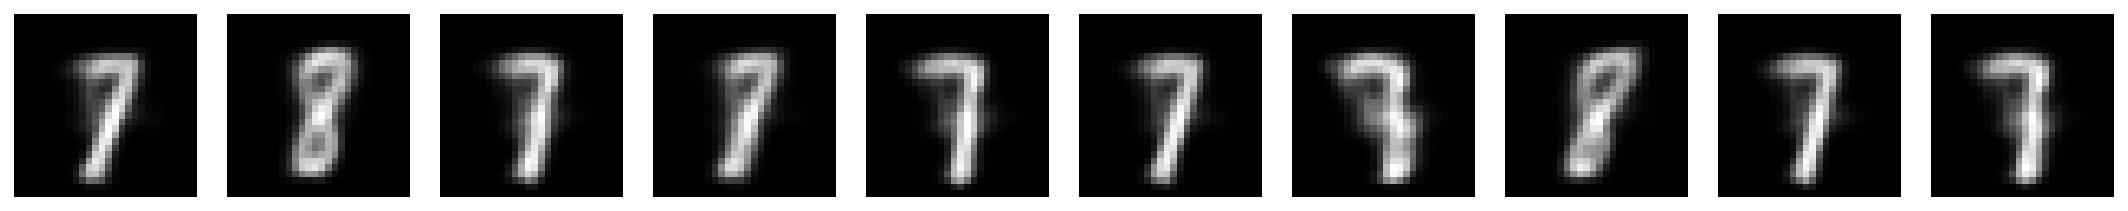

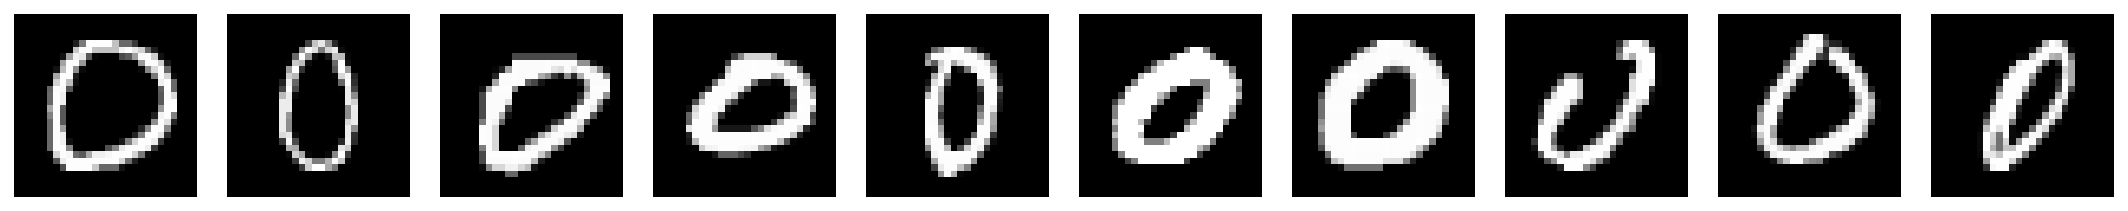

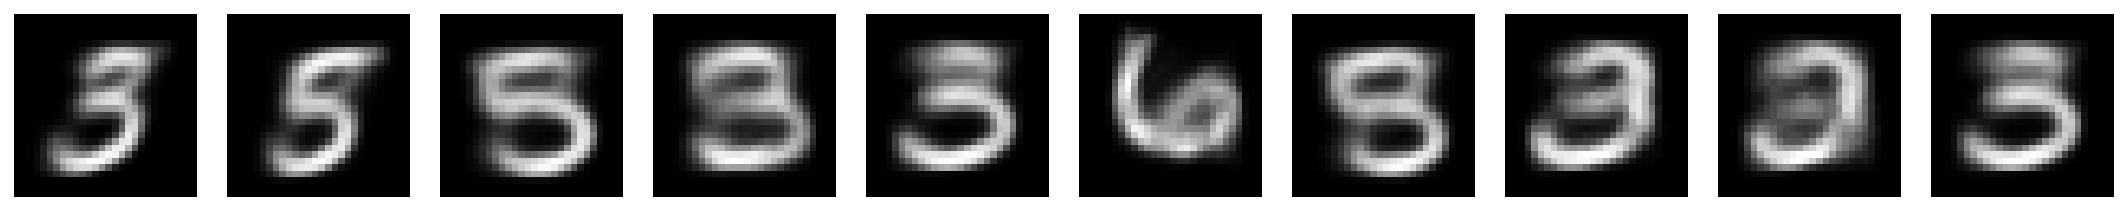

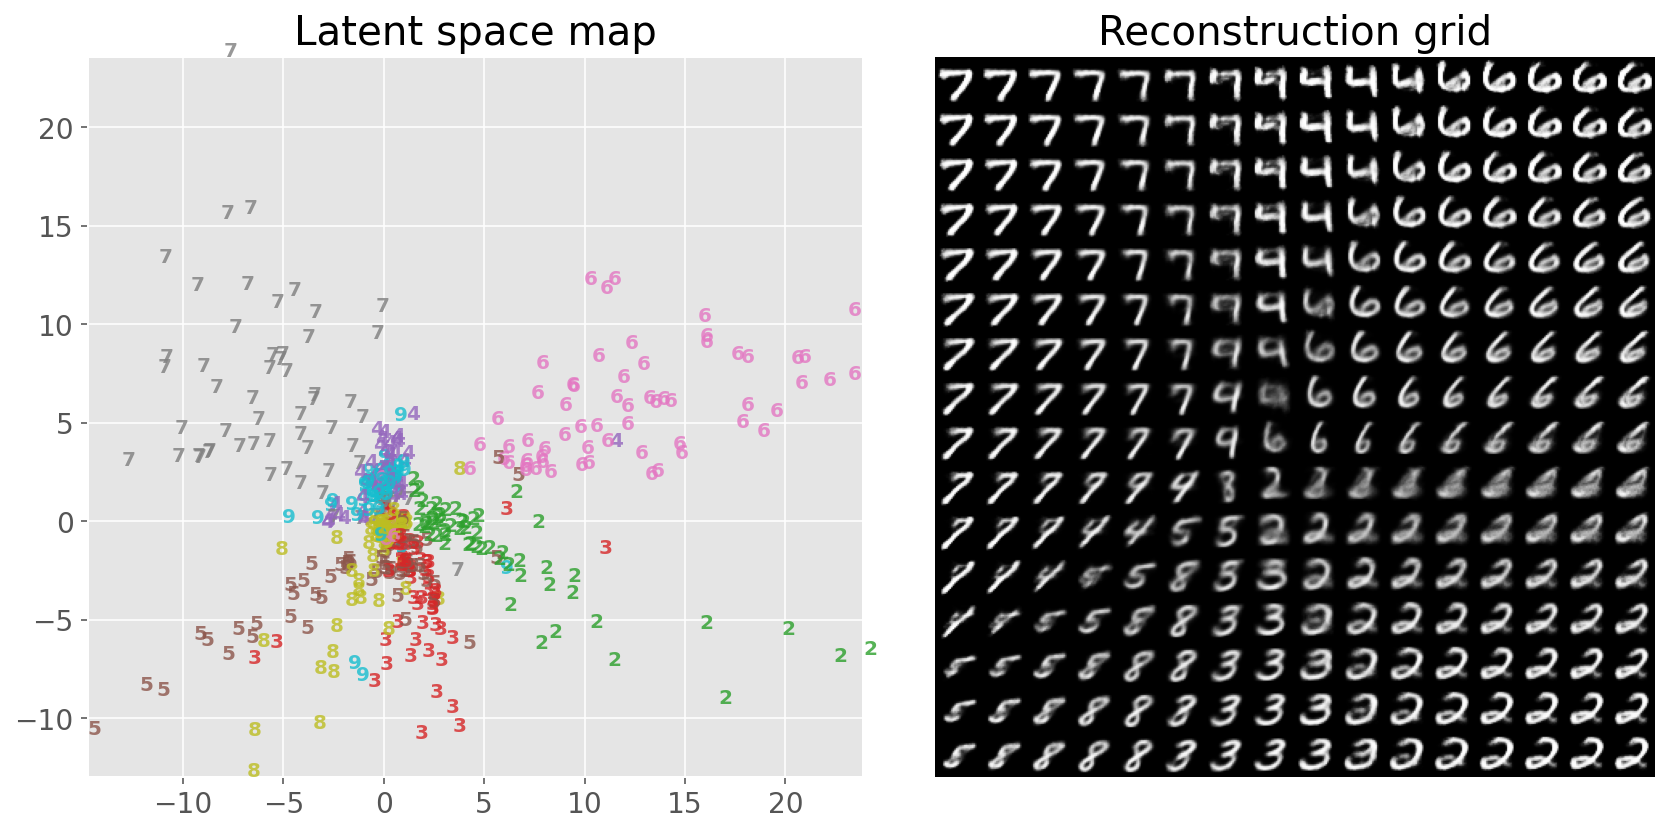

In [36]:
plot_row([input_test[y_test==missing_a], output_test[y_test==missing_a]], image_shape=image_shape)
plot_row([input_test[y_test==missing_b], output_test[y_test==missing_b]], image_shape=image_shape)

plot_latent_generative(my_latent_test, my_y_test, decoder, 
                       image_shape=image_shape, s2=s2)

## Summary
In this notebook, we observed the way autoencoders
build internal representations of the world in several toy applications.


**The data seen during the training process imprints a "cognitive bias" to autoencoders by directly affecting latent space representations and their reconstructions.**